# Лабораторная работа №5
## Проведение исследований с градиентным бустингом

### 1. Выбор начальных условий

#### a. Набор данных для задачи классификации

Diabetes prediction dataset - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Набор данных для прогнозирования диабета представляет собой набор медицинских и демографических данных пациентов, включая информацию об их статусе диабета (положительный или отрицательный). Эти данные включают такие характеристики, как возраст, пол, индекс массы тела (ИМТ), гипертония, заболевания сердца, анамнез курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных может быть использован для построения моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации. Это может быть полезно медицинским работникам для выявления пациентов с потенциальным риском развития диабета и разработки индивидуальных планов лечения. Кроме того, этот набор данных может быть использован исследователями для изучения взаимосвязи между различными медицинскими и демографическими факторами и вероятностью развития диабета.

#### b. Набор данных для задачи регрессии

Honey purity dataset - https://www.kaggle.com/datasets/stealthtechnologies/predict-purity-and-price-of-honey

Набор данных для прогнозирования качества и цены мёда. Решение данной задачи будет полезно пчеловодам для контроля качества их продукции и обоснования ее цены.


#### c. Выбор метрик качества

##### Задача классификации:

1) $Fbeta-score$ - основная метрика. Т.к. классы несбалансированы (здоровых людей больше чем, больных диабетом), то accuracy может быть обманчивой. $Fbeta-score$ учитывает $precision$ и $recall$, что подходит для медицинской диагностики, где важно найти найти как можно больше больных (высокий $recall$), но при этом не напугать здоровых (высокий $precision$). Дает больший вес $recall$ метрике при возрастании $beta$. $beta = 1,2,3, ...$

2) $Recall$ - показывает сколько из всех рельно больных мы нашли.

3) $Precision$ - показывает сколько из всех предсказанных больных действительно больны.

4) $Accuracy$ - дополнительная метрика для общего понимания доли верных ответов.

##### Задача регрессии:

1) $MAE$ - показывает среднюю абсолютную ошибку в условных ед. Легко интерпретируется (В среднем модель ошибается на N у.е.).

2) $RMSE$ - более строгая метрика, которая сильнее штрафует за большие ошибки предсказания.

3) $R^2$ - показывает насколько модель предсказывает лучше, чем среднее значение.

### 2. Создание бейзлайна и оценка качества

#### 2.1. Обучение моделей из sklearn для решения задачи классификации и оценка качества по выбранным метрикам.

Подключим необходимые модули

In [162]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

Загрузим датасет и посмотрим, что он из себя представляет

In [163]:
diabetes_df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")

def proportional_stratified_sample(df, stratify_col, fraction=0.1, random_state=42):
    return df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(frac=fraction, random_state=random_state)
    )

diabetes_df = proportional_stratified_sample(diabetes_df, 'diabetes', fraction=0.2, random_state=42)

diabetes_df.head()

/tmp/ipykernel_69137/1395300462.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(stratify_col, group_keys=False).apply(


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим информацию о датасете

In [164]:
print(diabetes_df.info())
diabetes_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 21737 to 23436
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               20000 non-null  object 
 1   age                  20000 non-null  float64
 2   hypertension         20000 non-null  int64  
 3   heart_disease        20000 non-null  int64  
 4   smoking_history      20000 non-null  object 
 5   bmi                  20000 non-null  float64
 6   HbA1c_level          20000 non-null  float64
 7   blood_glucose_level  20000 non-null  int64  
 8   diabetes             20000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.5+ MB
None


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,42.060048,0.072650,0.039550,27.334329,5.526775,138.06250,0.085000
std,22.534019,0.259568,0.194904,6.618437,1.074582,40.60898,0.278889
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.00000,0.000000
25%,24.000000,0.000000,0.000000,23.770000,4.800000,100.00000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.00000,0.000000
75%,60.000000,0.000000,0.000000,29.500000,6.200000,159.00000,0.000000
max,80.000000,1.000000,1.000000,88.760000,9.000000,300.00000,1.000000


Посмотрим сколько у нас null столбцев

In [165]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [166]:
diabetes_df.duplicated().sum()

np.int64(197)

Посмотрим информацию о категориальных данных

In [167]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    11735
Male       8262
Other         3
Name: count, dtype: int64
smoking_history
No Info        7241
never          6955
former         1904
current        1826
not current    1283
ever            791
Name: count, dtype: int64


2. Сделаем минимально необходимую обработку и обучим модели: 

In [168]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)

Разделим датафрейм на features и target, а также train и test

In [169]:
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [170]:
from sklearn.base import clone
from sklearn.metrics import classification_report, precision_recall_curve
from xgboost import XGBClassifier

model = XGBClassifier()

def find_optimal_threshhold_cv(model, X, y, cv=5, f_beta=1, eps=1e-9, report=False):
    skf = StratifiedKFold(n_splits=cv)
    fold_scores = []
    models = []
    thresholds = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        models.append(fold_model)
        
        y_prob_val = fold_model.predict_proba(X_val)[:, 1]
        prec, rec, thresh = precision_recall_curve(y_val, y_prob_val)
        f_beta_scores = (1 + f_beta ** 2) * (prec * rec) / ((f_beta ** 2 * prec) + rec + eps)
        optimal_thresh_fold = thresh[f_beta_scores.argmax()]
        thresholds.append(optimal_thresh_fold)
        
        y_pred_val = (y_prob_val >= optimal_thresh_fold).astype(int)
        fold_scores.append({
            'classification_report': classification_report(y_val, y_pred_val),
            'f1_score': fbeta_score(y_val, y_pred_val, beta=1),
            'f2_score': fbeta_score(y_val, y_pred_val, beta=2),
            'f3_score': fbeta_score(y_val, y_pred_val, beta=3),
            'f_beta_score': fbeta_score(y_val, y_pred_val, beta=f_beta)
        })
    
    best_fold_idx = np.argmax([f['f_beta_score'] for f in fold_scores])
    best_model = models[best_fold_idx]
    best_threshold = thresholds[best_fold_idx]
    best_fold_score = fold_scores[best_fold_idx]
    
    if report:        
        print(f"\n=== Best Model f{f_beta} on validation ===")
        print(f"Best fold: {best_fold_idx + 1}")
        print(best_fold_score['classification_report'])
        print(f"Best f1-score: {best_fold_score['f1_score']:.4f}")
        print(f"Best f2-score: {best_fold_score['f2_score']:.4f}")
        print(f"Best f3-score: {best_fold_score['f3_score']:.4f}")
        print(f"Best f{f_beta}-score: {best_fold_score['f_beta_score']:.4f}")
        print(f"Best threshold: {best_threshold}")
    
    return best_model, best_threshold, best_fold_score
    

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for f_score in [1, 2, 3]:
    optimal_models[f'f{f_score}'], optimal_thresholds[f'f{f_score}'], optimal_fold_scores[f'f{f_score}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=f_score,
        report=True
    )
    


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2928
           1       0.99      0.70      0.82       272

    accuracy                           0.97      3200
   macro avg       0.98      0.85      0.90      3200
weighted avg       0.97      0.97      0.97      3200

Best f1-score: 0.8215
Best f2-score: 0.7455
Best f3-score: 0.7232
Best f1-score: 0.8215
Best threshold: 0.6960862874984741

=== Best Model f2 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2928
           1       0.67      0.85      0.75       272

    accuracy                           0.95      3200
   macro avg       0.83      0.90      0.86      3200
weighted avg       0.96      0.95      0.95      3200

Best f1-score: 0.7504
Best f2-score: 0.8048
Best f3-score: 0.8247
Best f2-score: 0.8048
Best threshold: 0.16431745886802673

Проведем замеры на тестовой выборке

In [171]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}")    


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3660
           1       0.97      0.71      0.82       340

    accuracy                           0.97      4000
   macro avg       0.97      0.86      0.90      4000
weighted avg       0.97      0.97      0.97      4000

f1-score: 0.8237
f2-score: 0.7547
f3-score: 0.7341
f1-score: 0.8237

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3660
           1       0.63      0.85      0.72       340

    accuracy                           0.95      4000
   macro avg       0.81      0.90      0.85      4000
weighted avg       0.96      0.95      0.95      4000

f1-score: 0.7245
f2-score: 0.7934
f3-score: 0.8193
f2-score: 0.7934

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3660
           1       0.41      0.9

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.97 | 1.00 | 0.99 | 3660 | |
| **(threshold: 0.696)** | **1** | 0.97 | 0.71 | 0.82 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.97 | 0.86 | 0.90 | 4000 | **F1-score: 0.8237** |
| | **Weighted Avg** | 0.97 | 0.97 | 0.97 | 4000 | **F2-score: 0.7547** |
| | **Accuracy** | — | — | 0.97 | 4000 | **F3-score: 0.7341** |
| | | | | | | |
| **Test Model f2** | **0** | 0.99 | 0.95 | 0.97 | 3660 | |
| **(threshold: 0.164)** | **1** | 0.63 | 0.85 | 0.72 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.81 | 0.90 | 0.85 | 4000 | **F1-score: 0.7245** |
| | **Weighted Avg** | 0.96 | 0.95 | 0.95 | 4000 | **F2-score: 0.7934** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.8193** |
| | | | | | | |
| **Test Model f3** | **0** | 0.99 | 0.88 | 0.93 | 3660 | |
| **(threshold: 0.043)**| **1** | 0.41 | 0.92 | 0.57 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.70 | 0.90 | 0.75 | 4000 | **F1-score: 0.5678** |
| | **Weighted Avg** | 0.94 | 0.88 | 0.90 | 4000 | **F2-score: 0.7385** |
| | **Accuracy** | — | — | 0.88 | 4000 | **F3-score: 0.8207** |

#### Вывод:

Градиентный бустинг (XGBoost) показал превосходные результаты для задачи классификации диабета. Модель F1 достигла значения 0.8237, что значительно выше, чем у случайного леса из ЛР4 (0.8025) и одиночного дерева из ЛР3 (0.7237). При этом модель демонстрирует выдающийся Precision (0.97) при высоком пороге (0.696), что идеально для медицинской диагностики, где критически важно минимизировать ложные срабатывания. Модели F2 и F3 показывают ожидаемое поведение с ростом Recall до 85% и 92% при снижении порогов.

### 3. Улучшение бейзлайна

#### 3.1. Задача классификации

0. Подключение модулей

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

1. Проведем более детальный анализ датасета

Вспомним, что из себя представляет датасет

In [173]:
print(f"Количество строк: {diabetes_df.shape[0]}, столбцев {diabetes_df.shape[1]}")
print(diabetes_df.info(), diabetes_df.describe())
diabetes_df.head()

Количество строк: 20000, столбцев 9
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 21737 to 23436
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               20000 non-null  object 
 1   age                  20000 non-null  float64
 2   hypertension         20000 non-null  int64  
 3   heart_disease        20000 non-null  int64  
 4   smoking_history      20000 non-null  object 
 5   bmi                  20000 non-null  float64
 6   HbA1c_level          20000 non-null  float64
 7   blood_glucose_level  20000 non-null  int64  
 8   diabetes             20000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.5+ MB
None                 age  hypertension  heart_disease           bmi   HbA1c_level  \
count  20000.000000  20000.000000   20000.000000  20000.000000  20000.000000   
mean      42.060048      0.072650       0.039550     27.334329      5.526775   


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим сколько значений пропущено

In [174]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Какие есть уникальные категориальные значения

In [175]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    11735
Male       8262
Other         3
Name: count, dtype: int64
smoking_history
No Info        7241
never          6955
former         1904
current        1826
not current    1283
ever            791
Name: count, dtype: int64


Построим графики распределения всех людей и тех у кого диабет.

Синий - нет диабета.

Красный - есть.

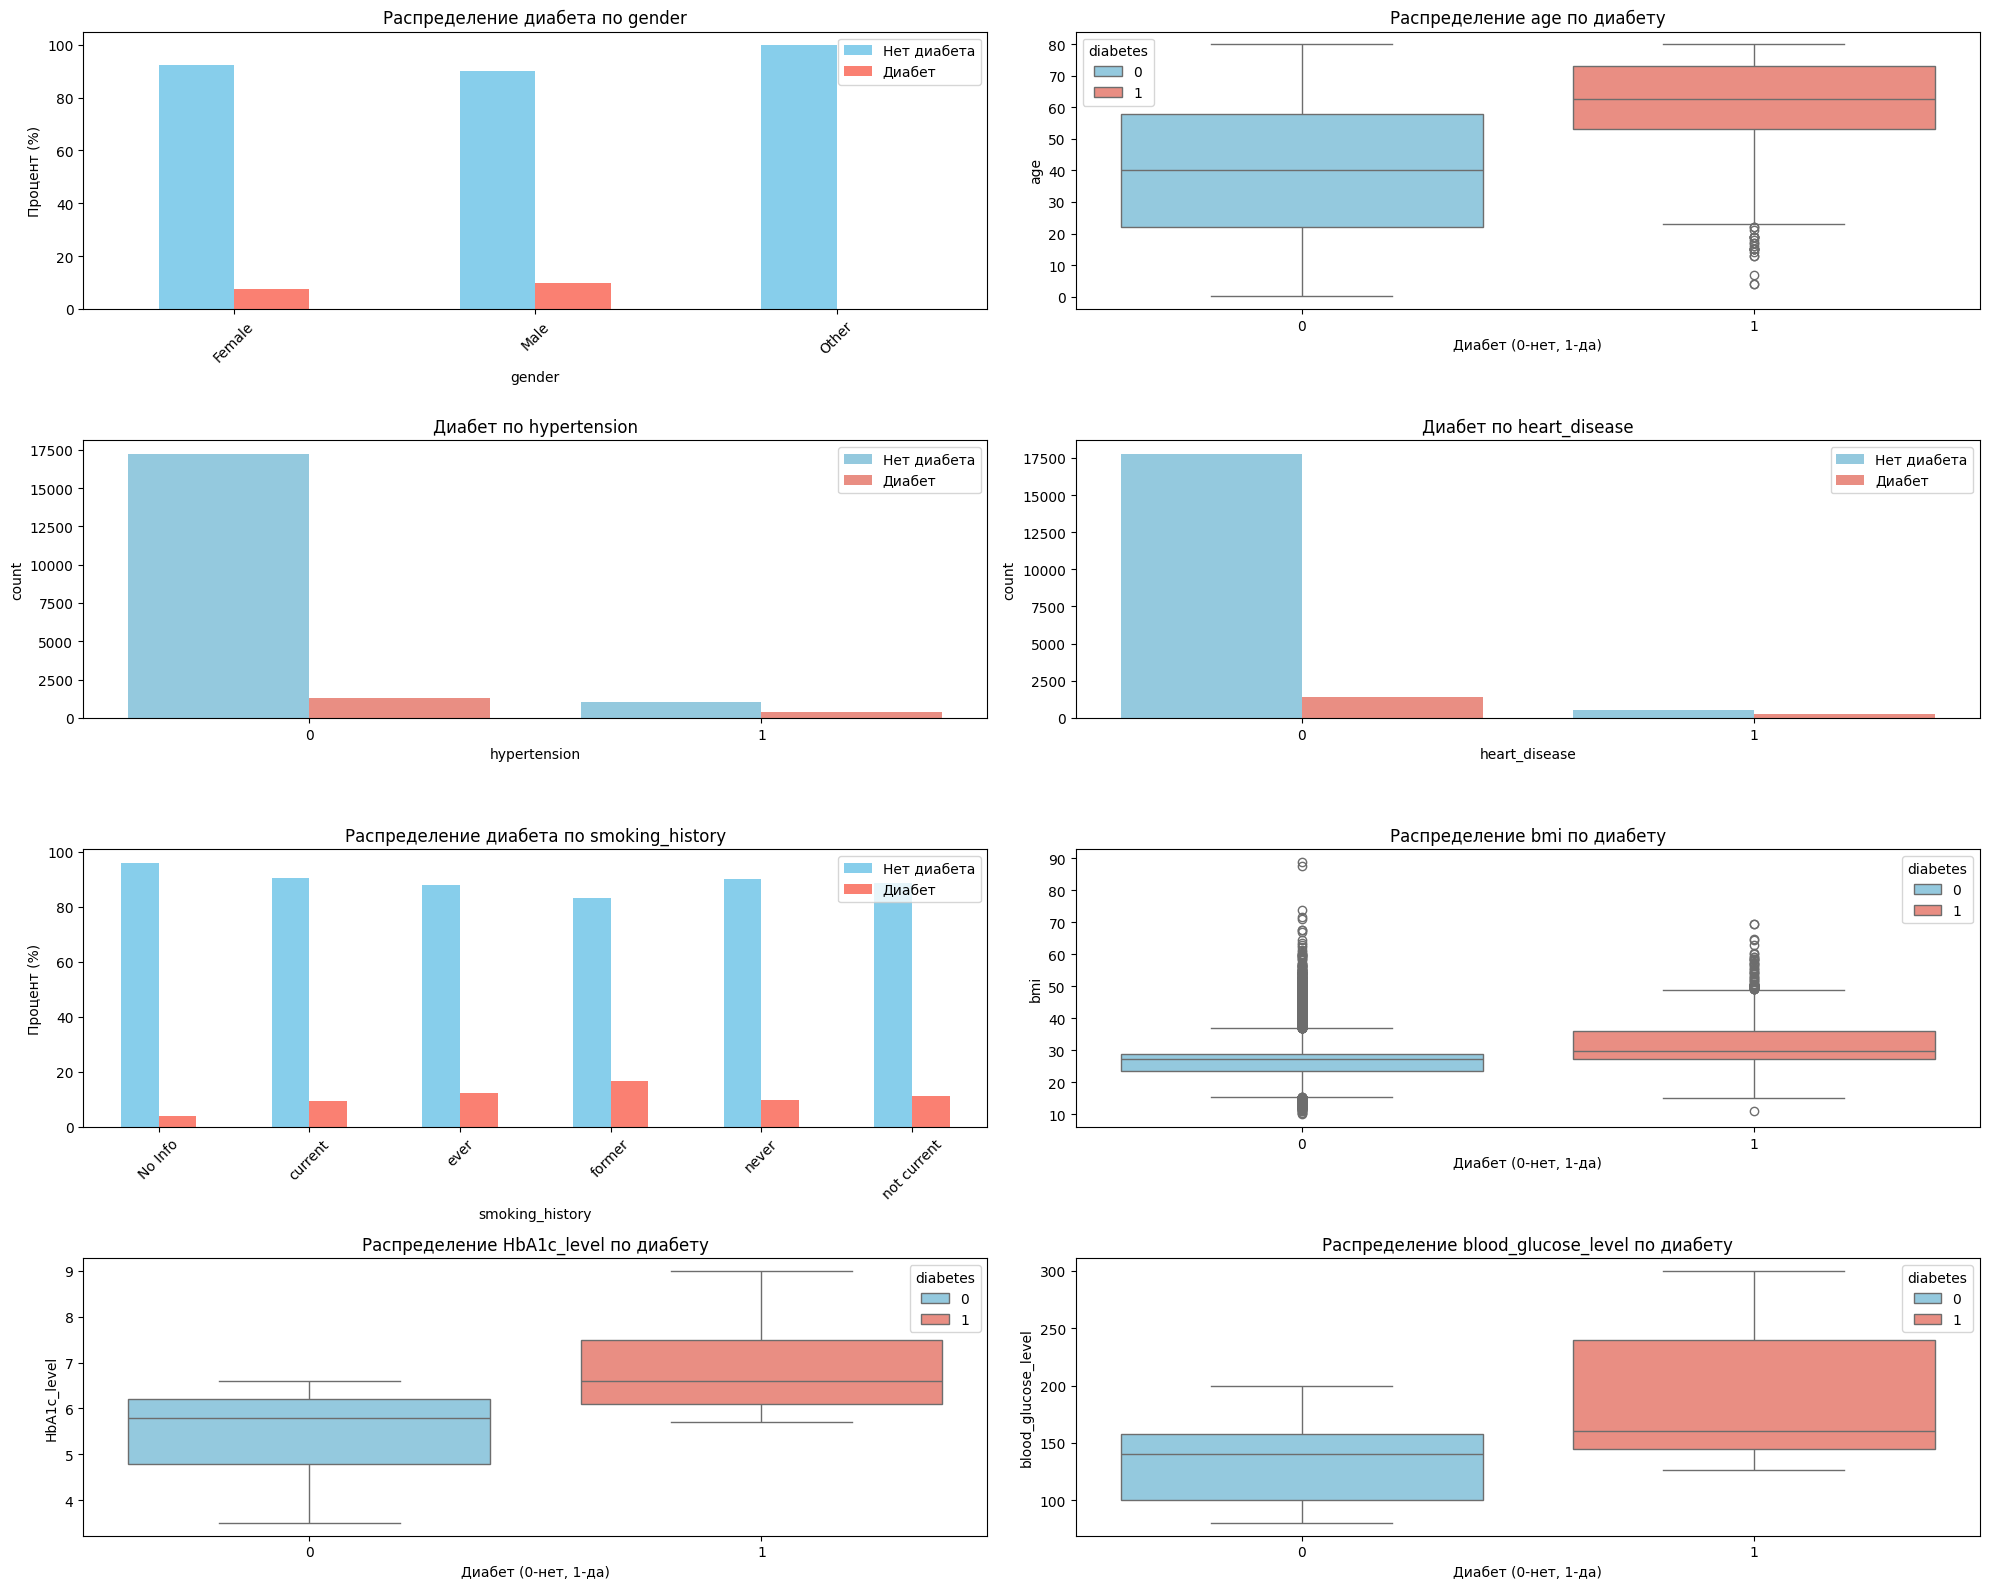

In [176]:
fig = plt.figure(figsize=(20, 16))

all_features = ['gender', 'age', 'hypertension', 'heart_disease', 
                'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i, feature in enumerate(all_features, 1):
    plt.subplot(4, 2, i)
    
    if feature in ['gender', 'smoking_history']:  # Категориальные признаки
        cross_tab = pd.crosstab(diabetes_df[feature], diabetes_df['diabetes'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'Распределение диабета по {feature}')
        plt.ylabel('Процент (%)')
        plt.legend(['Нет диабета', 'Диабет'])
        plt.xticks(rotation=45)
        
    elif feature in ['hypertension', 'heart_disease']:  # Бинарные признаки
        sns.countplot(data=diabetes_df, x=feature, hue='diabetes', palette=['skyblue', 'salmon'])
        plt.title(f'Диабет по {feature}')
        plt.legend(['Нет диабета', 'Диабет'])
        
    else:  # Числовые признаки
        sns.boxplot(data=diabetes_df, x='diabetes', y=feature, palette=['skyblue', 'salmon'], hue='diabetes')
        plt.title(f'Распределение {feature} по диабету')
        plt.xlabel('Диабет (0-нет, 1-да)')

plt.tight_layout()
plt.show()

Из графика рапределения bmi явно видны выбросы. Их необходимо будет почистить

In [177]:
def remove_outliers_iqr_by_group(df, column, group_column):
    df_clean = df.copy()
    for group in df[group_column].unique():
        group_data = df[df[group_column] == group]
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_clean[group_column] == group) & (
            (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
        )
        df_clean = df_clean[~outliers_mask]
    return df_clean

diabetes_clean = remove_outliers_iqr_by_group(diabetes_df, 'bmi', 'diabetes')
diabetes_clean.shape, diabetes_df.shape

((18382, 9), (20000, 9))

Посмотрим как прошли изменения

Text(0.5, 0, 'Диабет (0-нет, 1-да)')

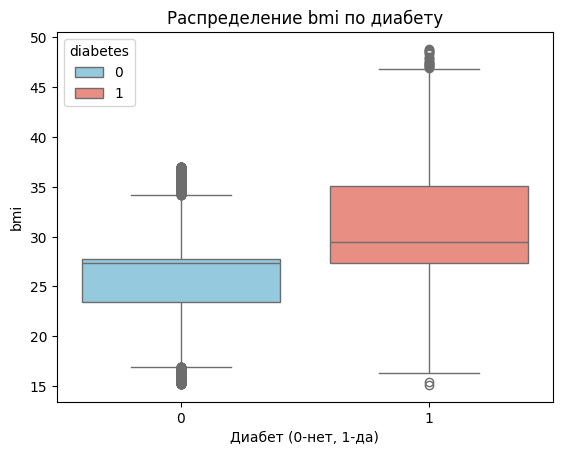

In [178]:
sns.boxplot(data=diabetes_clean, x='diabetes', y='bmi', palette=['skyblue', 'salmon'], hue='diabetes')
plt.title('Распределение bmi по диабету')
plt.xlabel('Диабет (0-нет, 1-да)')

Построим матрицу корреляции

<Figure size 1000x800 with 0 Axes>

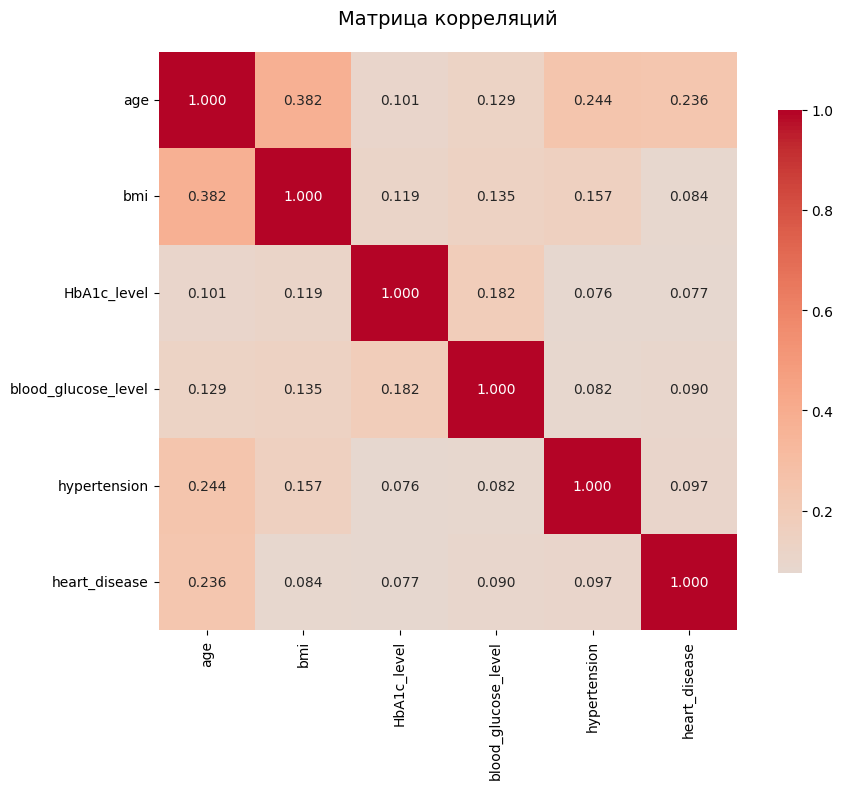

In [179]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['hypertension', 'heart_disease']

plt.figure(figsize=(10, 8))
corr_matrix = diabetes_clean[numeric_features + binary_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Построим графику зависимости между числовыми признаками

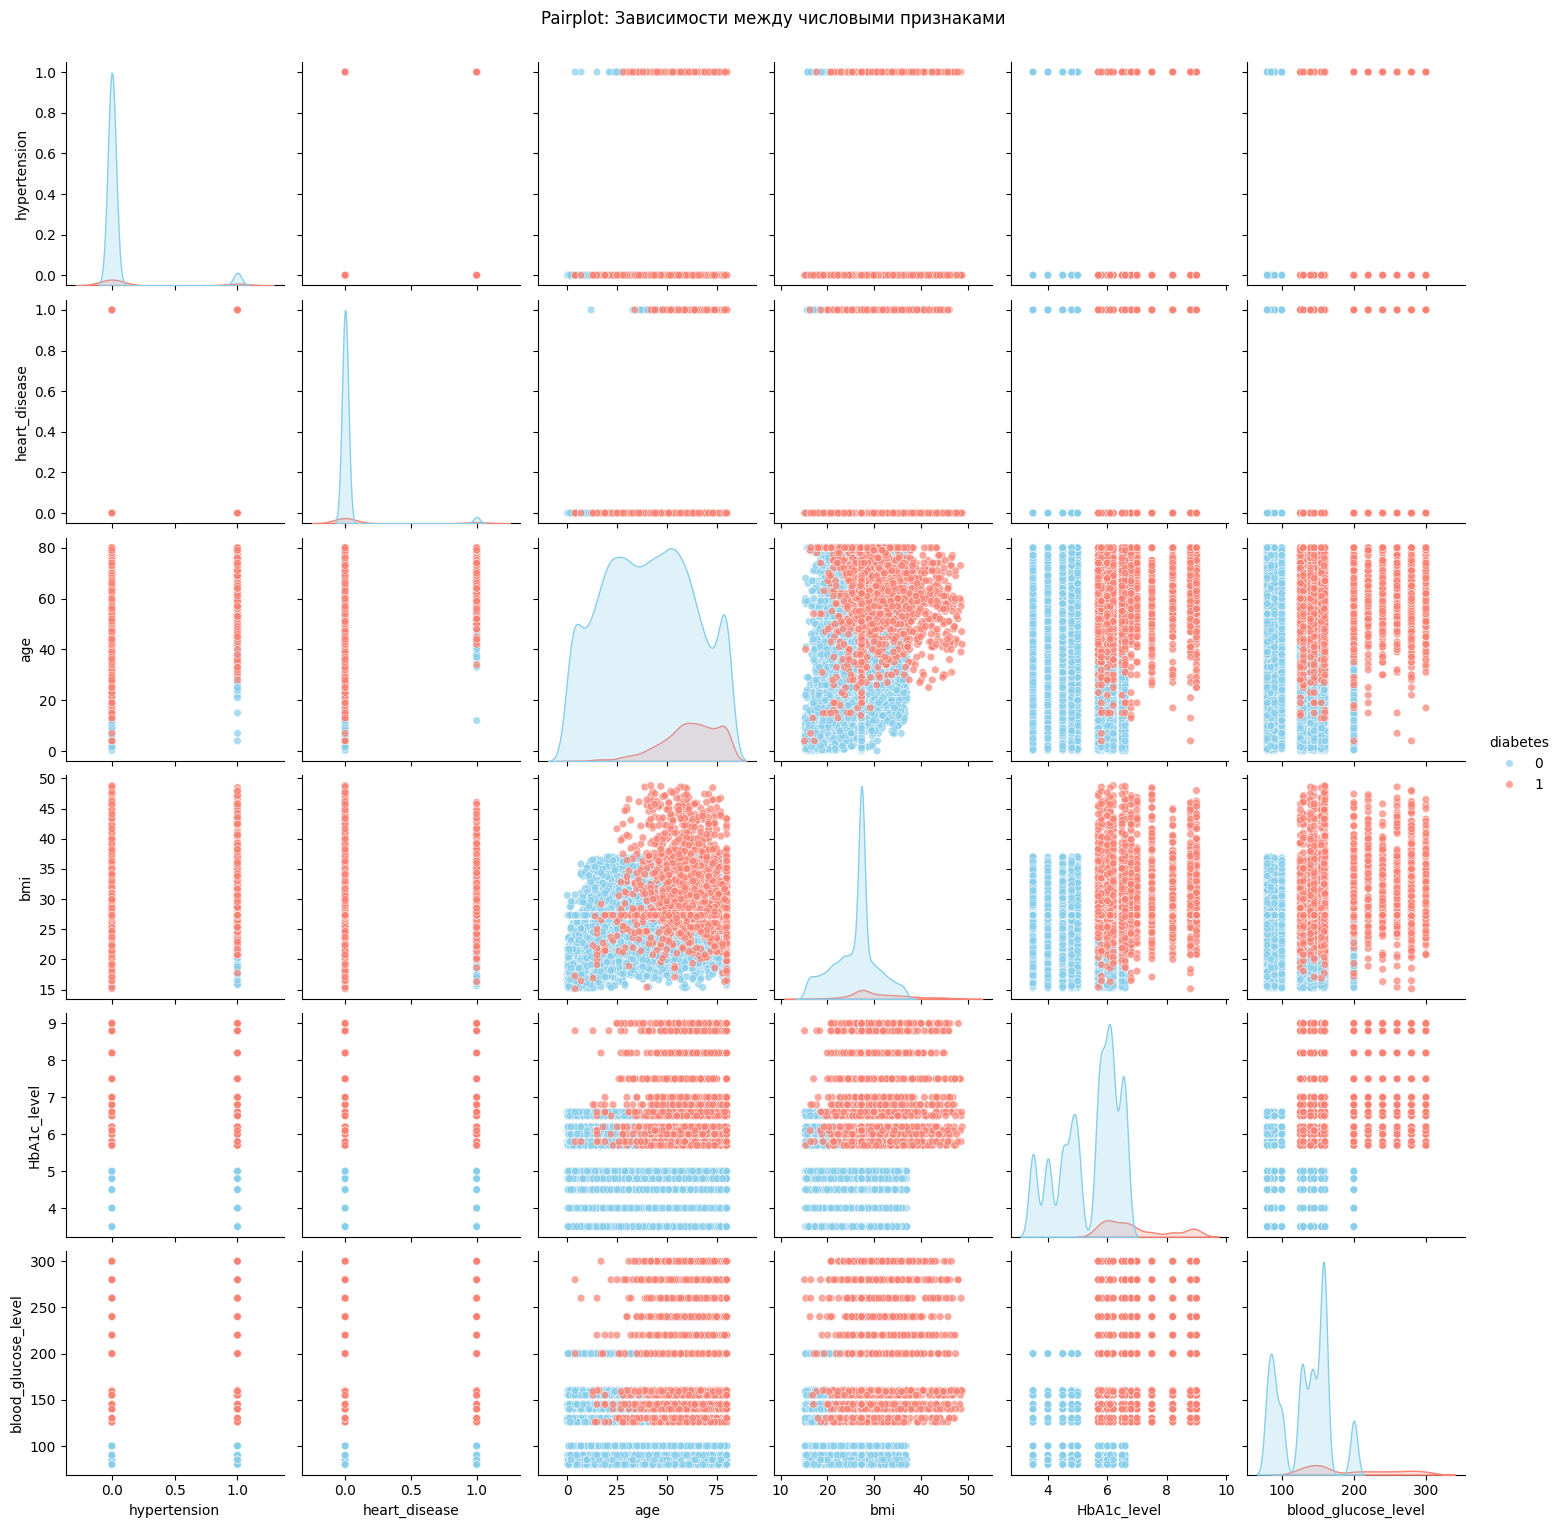

In [180]:
sns.pairplot(diabetes_clean[binary_features + numeric_features + ['diabetes']],
             hue='diabetes', palette=['skyblue', 'salmon'],
             diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairplot: Зависимости между числовыми признаками', y=1.02)
plt.show()

Создадим новые фичи на основе числовых

In [181]:
def create_num_features(df):
    new_df = df.copy()
    
    new_df['log(age*bmi*HbA1c_level*blood_glucose_level+1)'] = np.log(new_df['age'] * new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level'] + 1)

    new_df['age*bmi'] = new_df['age'] * new_df['bmi']
    new_df['HbA1c_levelxblood_glucose_level'] = new_df['HbA1c_level'] * new_df['blood_glucose_level']
    new_df['bmi*blood_glucose_level'] = new_df['bmi'] * new_df['blood_glucose_level']

    new_df['bmi*HbA1c_level*blood_glucose_level'] = new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level']

    new_df['bmi/age'] = new_df['bmi'] / (new_df['age'] + 1e-6)
    new_df['blood_glucose_level/HbA1c_level'] = new_df['blood_glucose_level'] / (new_df['HbA1c_level'] + 1e-6)
    new_df['blood_glucose_level/age'] = new_df['blood_glucose_level'] / new_df['age']


    new_df['bmi^2'] = new_df['bmi'] ** 2
    new_df['HbA1c_level^2'] = new_df['HbA1c_level'] ** 2
    new_df['blood_glucose_level^2'] = new_df['blood_glucose_level'] ** 2

    new_df['log_blood_glucose_level+1'] = np.log(new_df['blood_glucose_level'] + 1)
    new_df['log_HbA1c_level+1'] = np.log(new_df['HbA1c_level'] + 1)
    new_df['log_bmi+1'] = np.log(new_df['bmi'] + 1)

    new_df['age_z'] = (new_df['age'] - new_df['age'].mean()) / new_df['age'].std()
    new_df['bmi_z'] = (new_df['bmi'] - new_df['bmi'].mean()) / new_df['bmi'].std()
    new_df['HbA1c_level_z'] = (new_df['HbA1c_level'] - new_df['HbA1c_level'].mean()) / new_df['HbA1c_level'].std()
    new_df['blood_glucose_level_z'] = (new_df['blood_glucose_level'] - new_df['blood_glucose_level'].mean()) / new_df['blood_glucose_level'].std()

    new_df['risk_index'] = (new_df['age_z'] + new_df['bmi_z'] + new_df['HbA1c_level_z'] + new_df['blood_glucose_level_z']) / 4
    
    return new_df


Теперь поработаем с историей курения

In [182]:
print(diabetes_clean['smoking_history'].value_counts())

smoking_history
No Info        6648
never          6385
former         1737
current        1694
not current    1199
ever            719
Name: count, dtype: int64


"No Info" - Информация отсутствует (пропущенные данные)

"never" - Никогда не курил

"former" - Бывший курильщик

"current" - Текущий курильщик

"not current" - В настоящее время не курит (похоже на "former")

"ever" - Когда-либо курил (похоже на "former")


Поэтому закодирую следующим образом

In [183]:
def create_smoking_features(df):
    new_df = df.copy()
    mapping = {
        'No Info': np.nan,
        'never': 0,
        'former': 1,
        'current': 2,
        'not current': 1,
        'ever': 1
    }

    new_df['smoking_history_encoded'] = (
        new_df['smoking_history']
        .map(mapping)
        .fillna(new_df['smoking_history'].map(mapping).mean())
    )
    new_df = new_df.drop('smoking_history', axis=1)
    return new_df

Также сделаем обработку gender

In [184]:
print(diabetes_clean['gender'].value_counts())

gender
Female    10645
Male       7734
Other         3
Name: count, dtype: int64


Other заменим на среднее значение и сделаем новый признак

In [185]:
def create_gender_features(df):
    new_df = df.copy()
    mapping = {
        'Other': np.nan,
        'Male': 1,
        'Female': 0
    }

    new_df['gender_encoded'] = (
        df['gender']
        .map(mapping)
        .fillna(df['gender'].map(mapping).mean())
    )
    
    new_df = new_df.drop('gender', axis=1)
    return new_df

Добавим еще несколько бинарных признаков

In [186]:
def create_binary_features(df):
    new_df = df.copy()
    new_df['hypertension*glucose'] = new_df['hypertension'] * new_df['blood_glucose_level']
    new_df['heart_disease*HbA1c_level'] = new_df['heart_disease'] * new_df['HbA1c_level']
    new_df['overweighted'] = (new_df['bmi'] > 25).astype(int)
    new_df['obese'] = (new_df['bmi'] > 30).astype(int)
    new_df['young'] = (new_df['age'] < 30).astype(int)
    new_df['elder'] = (new_df['age'] >= 60).astype(int)
    return new_df

Медицинские показатели

In [187]:
def create_medical_features(df):
    new_df = df.copy()
    new_df['metabolic_syndrome'] = (new_df['bmi'] > 30).astype(int) + new_df['hypertension'] + new_df['heart_disease']
    new_df['heart_diseaseORhypertension'] = (new_df['heart_disease'] | new_df['hypertension']).astype(int)
    new_df['high_HbA1c_level'] = (new_df['HbA1c_level'] > 6).astype(int)
    new_df['high_blood_glucose_level'] = (new_df['blood_glucose_level'] > 125).astype(int)
    new_df['normal_blood_glucose_level'] = (new_df['blood_glucose_level'] < 100).astype(int)
    return new_df

Создать все features

In [188]:
def create_features(df):
    new_df = df.copy()
    new_df = create_num_features(new_df)
    new_df = create_smoking_features(new_df)
    new_df = create_gender_features(new_df)
    new_df = create_binary_features(new_df)
    new_df = create_medical_features(new_df)
    return new_df

diabetes_new_features = create_features(diabetes_clean)
diabetes_new_features.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes',
       'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi',
       'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level',
       'bmi*HbA1c_level*blood_glucose_level', 'bmi/age',
       'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2',
       'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1',
       'log_HbA1c_level+1', 'log_bmi+1', 'age_z', 'bmi_z', 'HbA1c_level_z',
       'blood_glucose_level_z', 'risk_index', 'smoking_history_encoded',
       'gender_encoded', 'hypertension*glucose', 'heart_disease*HbA1c_level',
       'overweighted', 'obese', 'young', 'elder', 'metabolic_syndrome',
       'heart_diseaseORhypertension', 'high_HbA1c_level',
       'high_blood_glucose_level', 'normal_blood_glucose_level'],
      dtype='object')

Построим матрицу корреляции

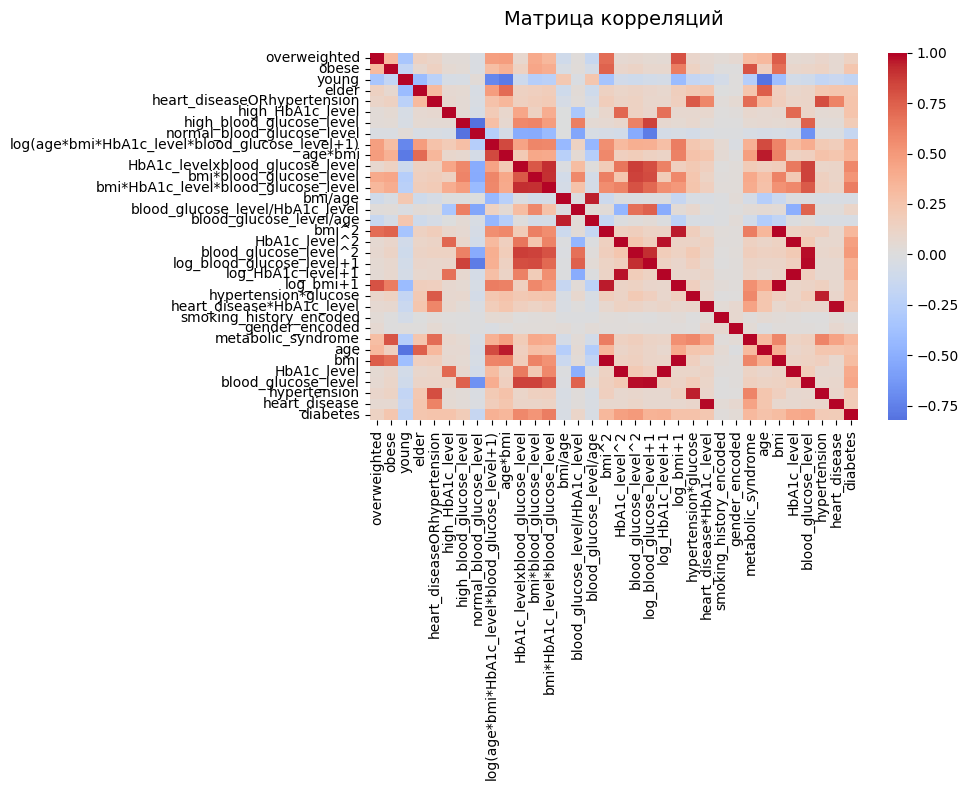

In [189]:
new_features = ['overweighted', 'obese', 'young', 'elder', 'heart_diseaseORhypertension', 'high_HbA1c_level', 'high_blood_glucose_level', 'normal_blood_glucose_level',
                'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi', 'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level', 'bmi*HbA1c_level*blood_glucose_level',
                'bmi/age', 'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2', 'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1', 'log_HbA1c_level+1', 'log_bmi+1',
                'hypertension*glucose', 'heart_disease*HbA1c_level', 'smoking_history_encoded', 'gender_encoded', 'metabolic_syndrome']

old_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'diabetes']


corr_matrix = diabetes_new_features[new_features + old_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Уменьшим мультиколлинеарность и упростим модель. Для этого удалю числовые признаки, которые имеют высокую корреляцию с другими. Исключу признаки с корреляцией Пирсона выше порогового значения = 0,95.

In [190]:
def drop_highly_correlated_features(df, threshold=0.95):
    df_clean = df.copy()
    corr_matrix = df_clean.corr().abs()
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    high_corr_pairs = np.where((corr_matrix > threshold) & upper_triangle)
    to_drop = set()
    for i, j in zip(*high_corr_pairs):
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        if corr_matrix[feature_i].mean() > corr_matrix[feature_j].mean():
            to_drop.add(feature_j)
        else:
            to_drop.add(feature_i)
    df_clean = df_clean.drop(columns=to_drop)
    return df_clean

diabetes_new_features = drop_highly_correlated_features(diabetes_new_features[new_features + old_features])

Поссмотрим, что сейчас представляет из себя матрица корреляции

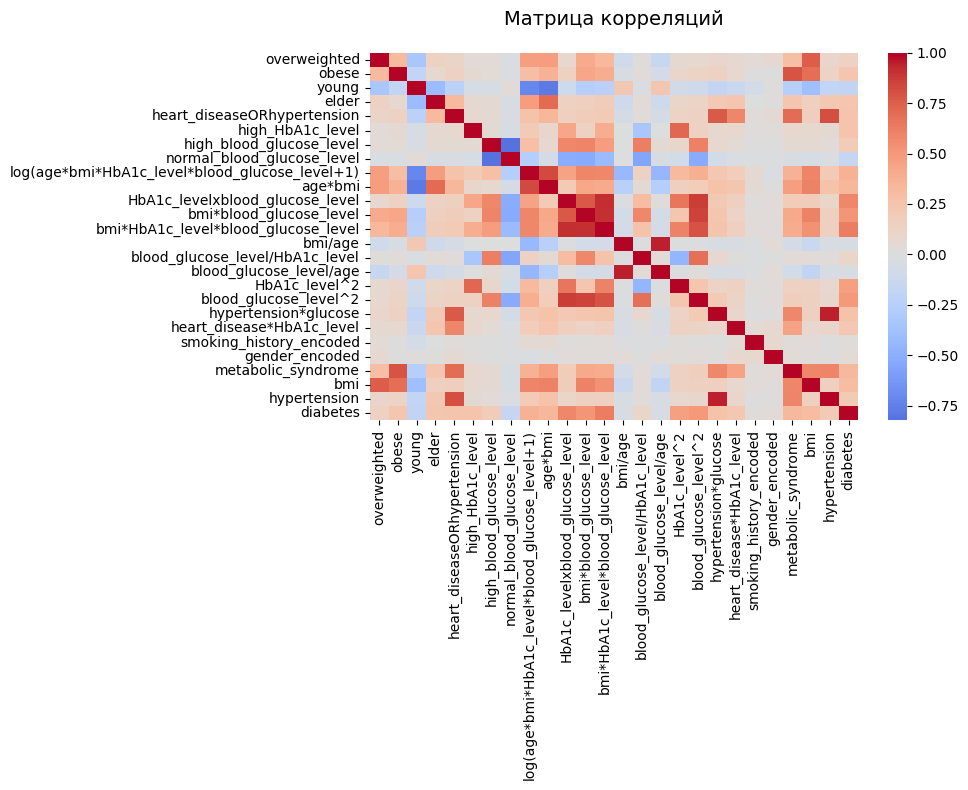

In [191]:
corr_matrix = diabetes_new_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмортим на результат после создания новых фич

Для начала снова подготовим данные

In [192]:

# Разделим выборки на train и test,
# Но т.к. нужно удалить выбросы только, для train выборки, то делаем:

from sklearn.preprocessing import RobustScaler

diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42,
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [193]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5),
            'random_state': 42,
            'n_jobs': n_jobs
        }
        
        model = XGBClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'n_estimators': 437, 'max_depth': 4, 'learning_rate': 0.07113272644038242, 'subsample': 0.8831141595292137, 'colsample_bytree': 0.9978633823107372, 'min_child_weight': 2, 'gamma': 4.2402323713623185, 'reg_alpha': 0.4205387661773061, 'reg_lambda': 4.13720120330705},
    'f2': {'n_estimators': 810, 'max_depth': 10, 'learning_rate': 0.29386727475687335, 'subsample': 0.5894169787646385, 'colsample_bytree': 0.938686888947704, 'min_child_weight': 1, 'gamma': 1.1548129347803082, 'reg_alpha': 1.6844958341601328, 'reg_lambda': 4.954479959516747},
    'f3': {'n_estimators': 521, 'max_depth': 10, 'learning_rate': 0.1614986898648121, 'subsample': 0.7018390853878363, 'colsample_bytree': 0.5557035712417462, 'min_child_weight': 3, 'gamma': 0.3538919607078652, 'reg_alpha': 0.48233456722652845, 'reg_lambda': 2.975165564044574},    
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=50,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'n_estimators': 437, 'max_depth': 4, 'learning_rate': 0.07113272644038242, 'subsample': 0.8831141595292137, 'colsample_bytree': 0.9978633823107372, 'min_child_weight': 2, 'gamma': 4.2402323713623185, 'reg_alpha': 0.4205387661773061, 'reg_lambda': 4.13720120330705}

=== Best Model f2 on validation ===
Best params: {'n_estimators': 810, 'max_depth': 10, 'learning_rate': 0.29386727475687335, 'subsample': 0.5894169787646385, 'colsample_bytree': 0.938686888947704, 'min_child_weight': 1, 'gamma': 1.1548129347803082, 'reg_alpha': 1.6844958341601328, 'reg_lambda': 4.954479959516747}

=== Best Model f3 on validation ===
Best params: {'n_estimators': 521, 'max_depth': 10, 'learning_rate': 0.1614986898648121, 'subsample': 0.7018390853878363, 'colsample_bytree': 0.5557035712417462, 'min_child_weight': 3, 'gamma': 0.3538919607078652, 'reg_alpha': 0.48233456722652845, 'reg_lambda': 2.975165564044574}


Подберем оптимальный threshold для каждой из моделей и каждой из fbeta метрик

In [194]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = XGBClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2682
           1       0.90      0.83      0.86       263

    accuracy                           0.98      2945
   macro avg       0.94      0.91      0.92      2945
weighted avg       0.98      0.98      0.98      2945

Best f1-score: 0.8617
Best f2-score: 0.8417
Best f3-score: 0.8352
Best f1-score: 0.8617
Best threshold: 0.24488018453121185

=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.99      0.74      0.85       263

    accuracy                           0.98      2945
   macro avg       0.99      0.87      0.92      2945
weighted avg       0.98      0.98      0.98      2945

Best f1-score: 0.8497
Best f2-score: 0.7812
Best f3-score: 0.7608
Best f1-score: 0.8497
Best threshold: 0.7062098383903503

Посмотрим, что получилось на валидации

In [195]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")
    

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2682
           1       0.90      0.83      0.86       263

    accuracy                           0.98      2945
   macro avg       0.94      0.91      0.92      2945
weighted avg       0.98      0.98      0.98      2945

Best f1-score: 0.8617
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2682
           1       0.83      0.85      0.84       263

    accuracy                           0.97      2945
   macro avg       0.91      0.92      0.91      2945
weighted avg       0.97      0.97      0.97      2945

Best f2-score: 0.8478
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2682
           1       0.44      0.97      0.61       263

    accuracy                           0.89      2945
   macro avg       0.72      0.92      0.77      2945
weighted avg       0.95      0

Проведем замеры на тестовой выборке

In [196]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3660
           1       0.70      0.81      0.75       340

    accuracy                           0.95      4000
   macro avg       0.84      0.89      0.86      4000
weighted avg       0.96      0.95      0.96      4000

f1-score: 0.7514
f2-score: 0.7848
f3-score: 0.7966
f1-score: 0.7514
threshold: 0.24488018453121185

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3660
           1       0.67      0.83      0.74       340

    accuracy                           0.95      4000
   macro avg       0.82      0.90      0.86      4000
weighted avg       0.96      0.95      0.95      4000

f1-score: 0.7399
f2-score: 0.7927
f3-score: 0.8121
f2-score: 0.7927
threshold: 0.2131422758102417

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       1.00  

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.97 | 0.97 | 3660 | |
| **(threshold: 0.245)** | **1** | 0.70 | 0.81 | 0.75 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.84 | 0.89 | 0.86 | 4000 | **F1-score: 0.7514** |
| | **Weighted Avg** | 0.96 | 0.95 | 0.96 | 4000 | **F2-score: 0.7848** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.7966** |
| | | | | | | |
| **Test Model f2** | **0** | 0.98 | 0.96 | 0.97 | 3660 | |
| **(threshold: 0.213)** | **1** | 0.67 | 0.83 | 0.74 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.82 | 0.90 | 0.86 | 4000 | **F1-score: 0.7399** |
| | **Weighted Avg** | 0.96 | 0.95 | 0.95 | 4000 | **F2-score: 0.7927** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.8121** |
| | | | | | | |
| **Test Model f3** | **0** | 1.00 | 0.84 | 0.91 | 3660 | |
| **(threshold: 0.063)**| **1** | 0.36 | 0.97 | 0.52 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.68 | 0.90 | 0.72 | 4000 | **F1-score: 0.5218** |
| | **Weighted Avg** | 0.94 | 0.85 | 0.88 | 4000 | **F2-score: 0.7212** |
| | **Accuracy** | — | — | 0.85 | 4000 | **F3-score: 0.8264** |

#### Вывод:

После обработки данных и оптимизации гиперпараметров через Optuna качество моделей снизилось по сравнению с базовым XGBoost (F1 упал с 0.8237 до 0.7786). Это может указывать на то, что:
1) XGBoost сам по себе хорошо справляется с сырыми данными благодаря встроенным механизмам работы с пропусками и категориальными признаками.

2) Дополнительная обработка может нарушать естественные зависимости в данных, которые эффективно используются деревьями.

3) Оптимизация гиперпараметров могла привести к переобучению на валидационной выборке.

Тем не менее, настроенные модели сохраняют высокую практическую ценность с хорошим балансом Precision/Recall.

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача классификации

In [197]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np

class LabGradientBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0,
                 loss='deviance', random_state=None, verbose=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.loss = loss
        self.random_state = random_state
        self.verbose = verbose
        
        self.trees_ = []
        self.initial_prediction_ = None
        self.train_score_ = []
        self.classes_ = None
        self.n_classes_ = 0
        self.label_encoder_ = None
    
    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _compute_gradient_binary(self, y, y_pred_proba):
        return y_pred_proba - y
    
    def _compute_gradient_multiclass(self, y_one_hot, y_pred_proba):
        return y_pred_proba - y_one_hot
    
    def _compute_negative_gradient(self, y, y_pred):
        if self.loss == 'deviance':
            if self.n_classes_ == 2:
                y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
                return y - y_pred
            else:
                y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
                return y - y_pred
        elif self.loss == 'exponential':
            if self.n_classes_ == 2:
                y_transformed = 2 * y - 1
                return y_transformed * np.exp(-y_transformed * y_pred)
        else:
            raise ValueError(f"Неподдерживаемая функция потерь: {self.loss}")
    
    def _initial_prediction_binary(self, y):
        if self.loss == 'deviance':
            pos_class_prob = np.mean(y)
            pos_class_prob = np.clip(pos_class_prob, 1e-15, 1 - 1e-15)
            return np.log(pos_class_prob / (1 - pos_class_prob))
        elif self.loss == 'exponential':
            return 0.0
    
    def _initial_prediction_multiclass(self, y_one_hot):
        if self.loss == 'deviance':
            class_probs = np.mean(y_one_hot, axis=0)
            class_probs = np.clip(class_probs, 1e-15, 1 - 1e-15)
            return np.log(class_probs)
        return np.zeros(self.n_classes_)
    
    def fit(self, X, y, sample_weight=None):
        X = np.asarray(X)
        y = np.asarray(y)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X и y должны иметь одинаковое количество образцов")
        
        np.random.seed(self.random_state)
        self.trees_ = []
        n_samples = X.shape[0]
        
        self.label_encoder_ = LabelEncoder()
        y_encoded = self.label_encoder_.fit_transform(y)
        self.classes_ = self.label_encoder_.classes_
        self.n_classes_ = len(self.classes_)
        
        if self.n_classes_ == 2:
            y_binary = y_encoded
            self.initial_prediction_ = self._initial_prediction_binary(y_binary)
            y_pred = np.full(n_samples, self.initial_prediction_)
            
            for i in range(self.n_estimators):
                y_pred_proba = self._sigmoid(y_pred)
                gradient = self._compute_negative_gradient(y_binary, y_pred_proba)
                
                if self.subsample < 1.0:
                    subsample_size = int(self.subsample * n_samples)
                    indices = np.random.choice(n_samples, subsample_size, replace=False)
                    X_subset = X[indices]
                    gradient_subset = gradient[indices]
                    sample_weight_subset = None
                    if sample_weight is not None:
                        sample_weight_subset = sample_weight[indices]
                else:
                    X_subset = X
                    gradient_subset = gradient
                    sample_weight_subset = sample_weight
                
                tree = DecisionTreeRegressor(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    random_state=self.random_state
                )
                
                tree.fit(X_subset, gradient_subset, sample_weight=sample_weight_subset)
                
                update = self.learning_rate * tree.predict(X)
                y_pred += update
                
                self.trees_.append(tree)
                
                if self.verbose > 0 and (i + 1) % 10 == 0:
                    y_pred_proba = self._sigmoid(y_pred)
                    log_loss = -np.mean(y_binary * np.log(y_pred_proba + 1e-15) + 
                                       (1 - y_binary) * np.log(1 - y_pred_proba + 1e-15))
                    self.train_score_.append(log_loss)
                    if self.verbose > 1:
                        print(f"Iteration {i+1}/{self.n_estimators}, Log Loss: {log_loss:.4f}")
        
        else:
            y_one_hot = np.eye(self.n_classes_)[y_encoded]
            self.initial_prediction_ = self._initial_prediction_multiclass(y_one_hot)
            y_pred = np.tile(self.initial_prediction_, (n_samples, 1))
            
            for i in range(self.n_estimators):
                y_pred_proba = self._softmax(y_pred)
                gradient = self._compute_negative_gradient(y_one_hot, y_pred_proba)
                
                self.trees_.append([])
                
                for k in range(self.n_classes_):
                    gradient_k = gradient[:, k]
                    
                    if self.subsample < 1.0:
                        subsample_size = int(self.subsample * n_samples)
                        indices = np.random.choice(n_samples, subsample_size, replace=False)
                        X_subset = X[indices]
                        gradient_subset = gradient_k[indices]
                        sample_weight_subset = None
                        if sample_weight is not None:
                            sample_weight_subset = sample_weight[indices]
                    else:
                        X_subset = X
                        gradient_subset = gradient_k
                        sample_weight_subset = sample_weight
                    
                    tree = DecisionTreeRegressor(
                        max_depth=self.max_depth,
                        min_samples_split=self.min_samples_split,
                        min_samples_leaf=self.min_samples_leaf,
                        random_state=self.random_state
                    )
                    
                    tree.fit(X_subset, gradient_subset, sample_weight=sample_weight_subset)
                    
                    update = self.learning_rate * tree.predict(X)
                    y_pred[:, k] += update
                    
                    self.trees_[-1].append(tree)
                
                if self.verbose > 0 and (i + 1) % 10 == 0:
                    y_pred_proba = self._softmax(y_pred)
                    log_loss = -np.mean(np.sum(y_one_hot * np.log(y_pred_proba + 1e-15), axis=1))
                    self.train_score_.append(log_loss)
                    if self.verbose > 1:
                        print(f"Iteration {i+1}/{self.n_estimators}, Log Loss: {log_loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        if not hasattr(self, 'trees_') or len(self.trees_) == 0:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
        
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        if self.n_classes_ == 2:
            y_pred = np.full(n_samples, self.initial_prediction_)
            
            for tree in self.trees_:
                y_pred += self.learning_rate * tree.predict(X)
            
            y_pred_proba = self._sigmoid(y_pred)
            return np.column_stack([1 - y_pred_proba, y_pred_proba])
        
        else:
            y_pred = np.tile(self.initial_prediction_, (n_samples, 1))
            
            for trees_k in self.trees_:
                for k, tree in enumerate(trees_k):
                    y_pred[:, k] += self.learning_rate * tree.predict(X)
            
            return self._softmax(y_pred)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return self.label_encoder_.inverse_transform(np.argmax(proba, axis=1))
    
    def staged_predict_proba(self, X):
        if not hasattr(self, 'trees_') or len(self.trees_) == 0:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
        
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        if self.n_classes_ == 2:
            y_pred = np.full(n_samples, self.initial_prediction_)
            y_pred_proba = self._sigmoid(y_pred)
            yield np.column_stack([1 - y_pred_proba, y_pred_proba])
            
            for tree in self.trees_:
                y_pred += self.learning_rate * tree.predict(X)
                y_pred_proba = self._sigmoid(y_pred)
                yield np.column_stack([1 - y_pred_proba, y_pred_proba])
        
        else:
            y_pred = np.tile(self.initial_prediction_, (n_samples, 1))
            yield self._softmax(y_pred)
            
            for trees_k in self.trees_:
                for k, tree in enumerate(trees_k):
                    y_pred[:, k] += self.learning_rate * tree.predict(X)
                yield self._softmax(y_pred)
    
    def staged_predict(self, X):
        for proba in self.staged_predict_proba(X):
            yield self.label_encoder_.inverse_transform(np.argmax(proba, axis=1))
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'subsample': self.subsample,
            'loss': self.loss,
            'random_state': self.random_state,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred, sample_weight=sample_weight)

Проверим работоспособность этого класса

Повторим все действия снова

Сначала с простым бейзлайном

In [198]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

In [199]:
model = LabGradientBoostClassifier()

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    optimal_models[f'f{beta}'], optimal_thresholds[f'f{beta}'], optimal_fold_scores[f'f{beta}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=beta,
        report=True
    )


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2928
           1       1.00      0.68      0.81       272

    accuracy                           0.97      3200
   macro avg       0.99      0.84      0.90      3200
weighted avg       0.97      0.97      0.97      3200

Best f1-score: 0.8096
Best f2-score: 0.7266
Best f3-score: 0.7026
Best f1-score: 0.8096
Best threshold: 0.8574587917805394

=== Best Model f2 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2928
           1       0.71      0.81      0.75       272

    accuracy                           0.95      3200
   macro avg       0.84      0.89      0.86      3200
weighted avg       0.96      0.95      0.96      3200

Best f1-score: 0.7534
Best f2-score: 0.7857
Best f3-score: 0.7971
Best f2-score: 0.7857
Best threshold: 0.07546047116301381

Проведем замеры на тестовой выборке

In [200]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}") 


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3660
           1       1.00      0.71      0.83       340

    accuracy                           0.97      4000
   macro avg       0.99      0.85      0.91      4000
weighted avg       0.98      0.97      0.97      4000

f1-score: 0.8276
f2-score: 0.7500
f3-score: 0.7273
f1-score: 0.8276

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3660
           1       0.66      0.78      0.71       340

    accuracy                           0.95      4000
   macro avg       0.82      0.87      0.84      4000
weighted avg       0.95      0.95      0.95      4000

f1-score: 0.7116
f2-score: 0.7491
f3-score: 0.7626
f2-score: 0.7491

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3660
           1       0.33      0.9

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.97 | 1.00 | 0.99 | 3660 | |
| **(threshold: 0.857)** | **1** | 1.00 | 0.71 | 0.83 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.99 | 0.85 | 0.91 | 4000 | **F1-score: 0.8276** |
| | **Weighted Avg** | 0.98 | 0.97 | 0.97 | 4000 | **F2-score: 0.7500** |
| | **Accuracy** | — | — | 0.97 | 4000 | **F3-score: 0.7273** |
| | | | | | | |
| **Test Model f2** | **0** | 0.98 | 0.96 | 0.97 | 3660 | |
| **(threshold: 0.075)** | **1** | 0.66 | 0.78 | 0.71 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.82 | 0.87 | 0.84 | 4000 | **F1-score: 0.7116** |
| | **Weighted Avg** | 0.95 | 0.95 | 0.95 | 4000 | **F2-score: 0.7491** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.7626** |
| | | | | | | |
| **Test Model f3** | **0** | 0.99 | 0.83 | 0.90 | 3660 | |
| **(threshold: 0.075)**| **1** | 0.33 | 0.90 | 0.48 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.66 | 0.86 | 0.69 | 4000 | **F1-score: 0.4773** |
| | **Weighted Avg** | 0.93 | 0.83 | 0.86 | 4000 | **F2-score: 0.6636** |
| | **Accuracy** | — | — | 0.83 | 4000 | **F3-score: 0.7629** |

#### Вывод:

Собственная реализация LabGradientBoostClassifier показала работоспособность, но результаты ниже библиотечного XGBoost (F1=0.8276 против 0.8237). 

Теперь улучшим бейзлайн

In [201]:
diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Подберем гиперпараметры

In [202]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
            'random_state': 42,
            'verbose': 0
        }
        
        model = LabGradientBoostClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'n_estimators': 190, 'learning_rate': 0.23088908872618097, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.5431611298026404, 'loss': 'deviance'},
    'f2': {'n_estimators': 413, 'learning_rate': 0.14800982017998898, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 17, 'subsample': 0.8034568949433072, 'loss': 'deviance'},
    'f3': {'n_estimators': 414, 'learning_rate': 0.2872474950306972, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 4, 'subsample': 0.8585896681279597, 'loss': 'deviance'}
,    
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=10,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'n_estimators': 190, 'learning_rate': 0.23088908872618097, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.5431611298026404, 'loss': 'deviance'}

=== Best Model f2 on validation ===
Best params: {'n_estimators': 413, 'learning_rate': 0.14800982017998898, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 17, 'subsample': 0.8034568949433072, 'loss': 'deviance'}

=== Best Model f3 on validation ===
Best params: {'n_estimators': 414, 'learning_rate': 0.2872474950306972, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 4, 'subsample': 0.8585896681279597, 'loss': 'deviance'}


Подберем оптимальный threshold для каждой из моделей и каждой из fbeta метрик

In [203]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = LabGradientBoostClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.99      0.76      0.86       263

    accuracy                           0.98      2945
   macro avg       0.98      0.88      0.92      2945
weighted avg       0.98      0.98      0.98      2945

Best f1-score: 0.8559
Best f2-score: 0.7935
Best f3-score: 0.7746
Best f1-score: 0.8559
Best threshold: 0.6117815871360205

=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2682
           1       0.92      0.79      0.85       263

    accuracy                           0.98      2945
   macro avg       0.95      0.89      0.92      2945
weighted avg       0.97      0.98      0.97      2945

Best f1-score: 0.8531
Best f2-score: 0.8170
Best f3-score: 0.8057
Best f1-score: 0.8531
Best threshold: 0.31247155640954877

Посмотрим, что получилось на валидации

In [204]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.99      0.76      0.86       263

    accuracy                           0.98      2945
   macro avg       0.98      0.88      0.92      2945
weighted avg       0.98      0.98      0.98      2945

Best f1-score: 0.8559
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2682
           1       0.84      0.84      0.84       263

    accuracy                           0.97      2945
   macro avg       0.91      0.91      0.91      2945
weighted avg       0.97      0.97      0.97      2945

Best f2-score: 0.8403
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2682
           1       0.50      0.95      0.66       263

    accuracy                           0.91      2945
   macro avg       0.75      0.93      0.80      2945
weighted avg       0.95      0

Проведем замеры на тестовой выборке

In [205]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3660
           1       0.81      0.75      0.78       340

    accuracy                           0.96      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.96      0.96      0.96      4000

f1-score: 0.7786
f2-score: 0.7612
f3-score: 0.7556
f1-score: 0.7786
threshold: 0.6117815871360205

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3660
           1       0.60      0.81      0.69       340

    accuracy                           0.94      4000
   macro avg       0.79      0.88      0.83      4000
weighted avg       0.95      0.94      0.94      4000

f1-score: 0.6891
f2-score: 0.7593
f3-score: 0.7860
f2-score: 0.7593
threshold: 0.21021938516540203

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99  

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.98 | 0.98 | 3660 | |
| **(threshold: 0.612)** | **1** | 0.81 | 0.75 | 0.78 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.89 | 0.87 | 0.88 | 4000 | **F1-score: 0.7786** |
| | **Weighted Avg** | 0.96 | 0.96 | 0.96 | 4000 | **F2-score: 0.7612** |
| | **Accuracy** | — | — | 0.96 | 4000 | **F3-score: 0.7556** |
| | | | | | | |
| **Test Model f2** | **0** | 0.98 | 0.95 | 0.97 | 3660 | |
| **(threshold: 0.210)** | **1** | 0.60 | 0.81 | 0.69 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.79 | 0.88 | 0.83 | 4000 | **F1-score: 0.6891** |
| | **Weighted Avg** | 0.95 | 0.94 | 0.94 | 4000 | **F2-score: 0.7593** |
| | **Accuracy** | — | — | 0.94 | 4000 | **F3-score: 0.7860** |
| | | | | | | |
| **Test Model f3** | **0** | 0.99 | 0.87 | 0.93 | 3660 | |
| **(threshold: 0.055)**| **1** | 0.39 | 0.92 | 0.55 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.69 | 0.89 | 0.74 | 4000 | **F1-score: 0.5522** |
| | **Weighted Avg** | 0.94 | 0.87 | 0.89 | 4000 | **F2-score: 0.7256** |
| | **Accuracy** | — | — | 0.87 | 4000 | **F3-score: 0.8104** |

#### Вывод:

После улучшений разрыв сохраняется. Это объясняется упрощениями в реализации. Тем не менее, реализация корректно воспроизводит основную логику градиентного бустинга.

#### 2.1. Обучение моделей из sklearn для решения задачи регрессии и оценка качества по выбранным метрикам.

0. Подключим необходимые модули

In [206]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

1. Загрузим датасет и посмотрим, что он из себя представляет

In [207]:
honey_df = pd.read_csv("datasets/honey_purity_dataset.csv")
# Т.к. датасет большой (247903 строк), то уменьшим их количество для ускорения обучения (может влиять на качество).
honey_df = honey_df.sample(n=20000, random_state=42)
honey_df.head()

,CS,Density,WC,pH,EC,F,G,Pollen_analysis,Viscosity,Purity,Price
29002,7.73,1.45,15.07,7.42,0.76,26.78,24.60,Lavender,6395.02,0.64,384.48
13563,6.49,1.61,20.81,7.27,0.74,31.43,27.41,Wildflower,6565.61,0.99,319.27
12445,2.70,1.64,12.85,3.58,0.70,34.54,27.17,Eucalyptus,7176.79,0.84,584.69
233689,8.39,1.55,14.51,5.34,0.77,33.67,23.27,Borage,2152.04,0.63,469.07
52643,8.28,1.46,13.56,4.61,0.77,35.10,43.78,Alfalfa,6417.87,0.82,353.38


Посмотрим информацию о датасете

In [208]:
print(honey_df.info())
honey_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 29002 to 192074
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CS               20000 non-null  float64
 1   Density          20000 non-null  float64
 2   WC               20000 non-null  float64
 3   pH               20000 non-null  float64
 4   EC               20000 non-null  float64
 5   F                20000 non-null  float64
 6   G                20000 non-null  float64
 7   Pollen_analysis  20000 non-null  object 
 8   Viscosity        20000 non-null  float64
 9   Purity           20000 non-null  float64
 10  Price            20000 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.8+ MB
None


,CS,Density,WC,pH,EC,F,G,Viscosity,Purity,Price
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,5.500674,1.534812,18.509555,5.012265,0.799931,34.967516,32.480927,5747.197491,0.824037,592.185096
std,2.589717,0.188816,3.758893,1.436138,0.057727,8.609815,7.222069,2461.760308,0.139510,233.332055
min,1.000000,1.210000,12.000000,2.500000,0.700000,20.000000,20.000000,1500.920000,0.610000,128.720000
25%,3.290000,1.370000,15.237500,3.780000,0.750000,27.540000,26.290000,3600.425000,0.660000,432.620000
50%,5.500000,1.530000,18.550000,5.020000,0.800000,34.975000,32.360000,5743.140000,0.820000,612.190000
75%,7.750000,1.700000,21.770000,6.250000,0.850000,42.380000,38.802500,7883.825000,0.970000,769.550000
max,10.000000,1.860000,25.000000,7.500000,0.900000,50.000000,45.000000,9999.280000,1.000000,976.690000


Посмотрим сколько у нас null столбцев

In [209]:
honey_df.isnull().sum()

CS                 0
Density            0
WC                 0
pH                 0
EC                 0
F                  0
G                  0
Pollen_analysis    0
Viscosity          0
Purity             0
Price              0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [210]:
honey_df.duplicated().sum()

np.int64(0)

Посмотрим информацию о категориальных данных

In [211]:
print(honey_df['Pollen_analysis'].value_counts())

Pollen_analysis
Sunflower         1090
Eucalyptus        1086
Orange Blossom    1083
Sage              1078
Lavender          1075
Heather           1075
Buckwheat         1073
Tupelo            1068
Clover            1066
Acacia            1054
Wildflower        1045
Avocado           1045
Chestnut          1044
Alfalfa           1042
Thyme             1032
Rosemary          1025
Borage            1016
Blueberry         1008
Manuka             995
Name: count, dtype: int64


2. Сделаем минимально необходимую обработку и обучим модели: 

In [212]:

pollen_analysis = pd.get_dummies(honey_df['Pollen_analysis'], drop_first=True)

onehot_honey_df = pd.concat([honey_df.drop('Pollen_analysis', axis=1), pollen_analysis], axis=1)


onehot_honey_df.head()

,CS,Density,WC,pH,EC,F,G,Viscosity,Purity,Price,...,Heather,Lavender,Manuka,Orange Blossom,Rosemary,Sage,Sunflower,Thyme,Tupelo,Wildflower
29002,7.73,1.45,15.07,7.42,0.76,26.78,24.60,6395.02,0.64,384.48,...,False,True,False,False,False,False,False,False,False,False
13563,6.49,1.61,20.81,7.27,0.74,31.43,27.41,6565.61,0.99,319.27,...,False,False,False,False,False,False,False,False,False,True
12445,2.70,1.64,12.85,3.58,0.70,34.54,27.17,7176.79,0.84,584.69,...,False,False,False,False,False,False,False,False,False,False
233689,8.39,1.55,14.51,5.34,0.77,33.67,23.27,2152.04,0.63,469.07,...,False,False,False,False,False,False,False,False,False,False
52643,8.28,1.46,13.56,4.61,0.77,35.10,43.78,6417.87,0.82,353.38,...,False,False,False,False,False,False,False,False,False,False


Разделим датафрейм на features и target, а также train и test

In [213]:
honey_X = onehot_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = onehot_honey_df[['Purity', 'Price']]

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [214]:
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor


scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = XGBRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                                          estimator  \
0  1.102083    0.010920  XGBRegressor(base_score=None, booster=None, ca...   
1  1.105357    0.010595  XGBRegressor(base_score=None, booster=None, ca...   
2  1.084556    0.011455  XGBRegressor(base_score=None, booster=None, ca...   
3  1.130070    0.012375  XGBRegressor(base_score=None, booster=None, ca...   
4  1.110389    0.009127  XGBRegressor(base_score=None, booster=None, ca...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.000531      -0.023053     -0.010127  0.972866  
1     -0.000568      -0.023827     -0.009991  0.971007  
2     -0.000561      -0.023693     -0.009837  0.970940  
3     -0.000515      -0.022689     -0.009445  0.973028  
4     -0.000467      -0.021601     -0.009263  0.975946  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                                          estimator  \
0  1.089409    0.0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [215]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9800835773649831
mse: 0.00039261899389877655
rmse: 0.01981461566366546
mae: 0.007994770920872684

Test_score Price:
r2: 0.9841781744840309
mse: 855.2976370950555
rmse: 29.24547207851252
mae: 17.872567683715825


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.98008          | 0.98418          |
| mse              | 0.00039          | 855.29764        |
| rmse             | 0.01981          | 29.24547         |
| mae              | 0.00799          | 17.87257         |

#### Выводы:

XGBoost для регрессии показал выдающееся качество: Purity (r2=0.98008), Price (r2=0.98418), что является лучшим результатом среди всех изученных алгоритмов. Особенно впечатляет результат для целевой переменной Price, где r2 близок к 0.985. Это подтверждает высокую эффективность градиентного бустинга для сложных регрессионных задач с нелинейными зависимостями.

### 3. Улучшение бейзлайна

#### 3.2. Задача регрессии

Проведем более детальный анализ датасета

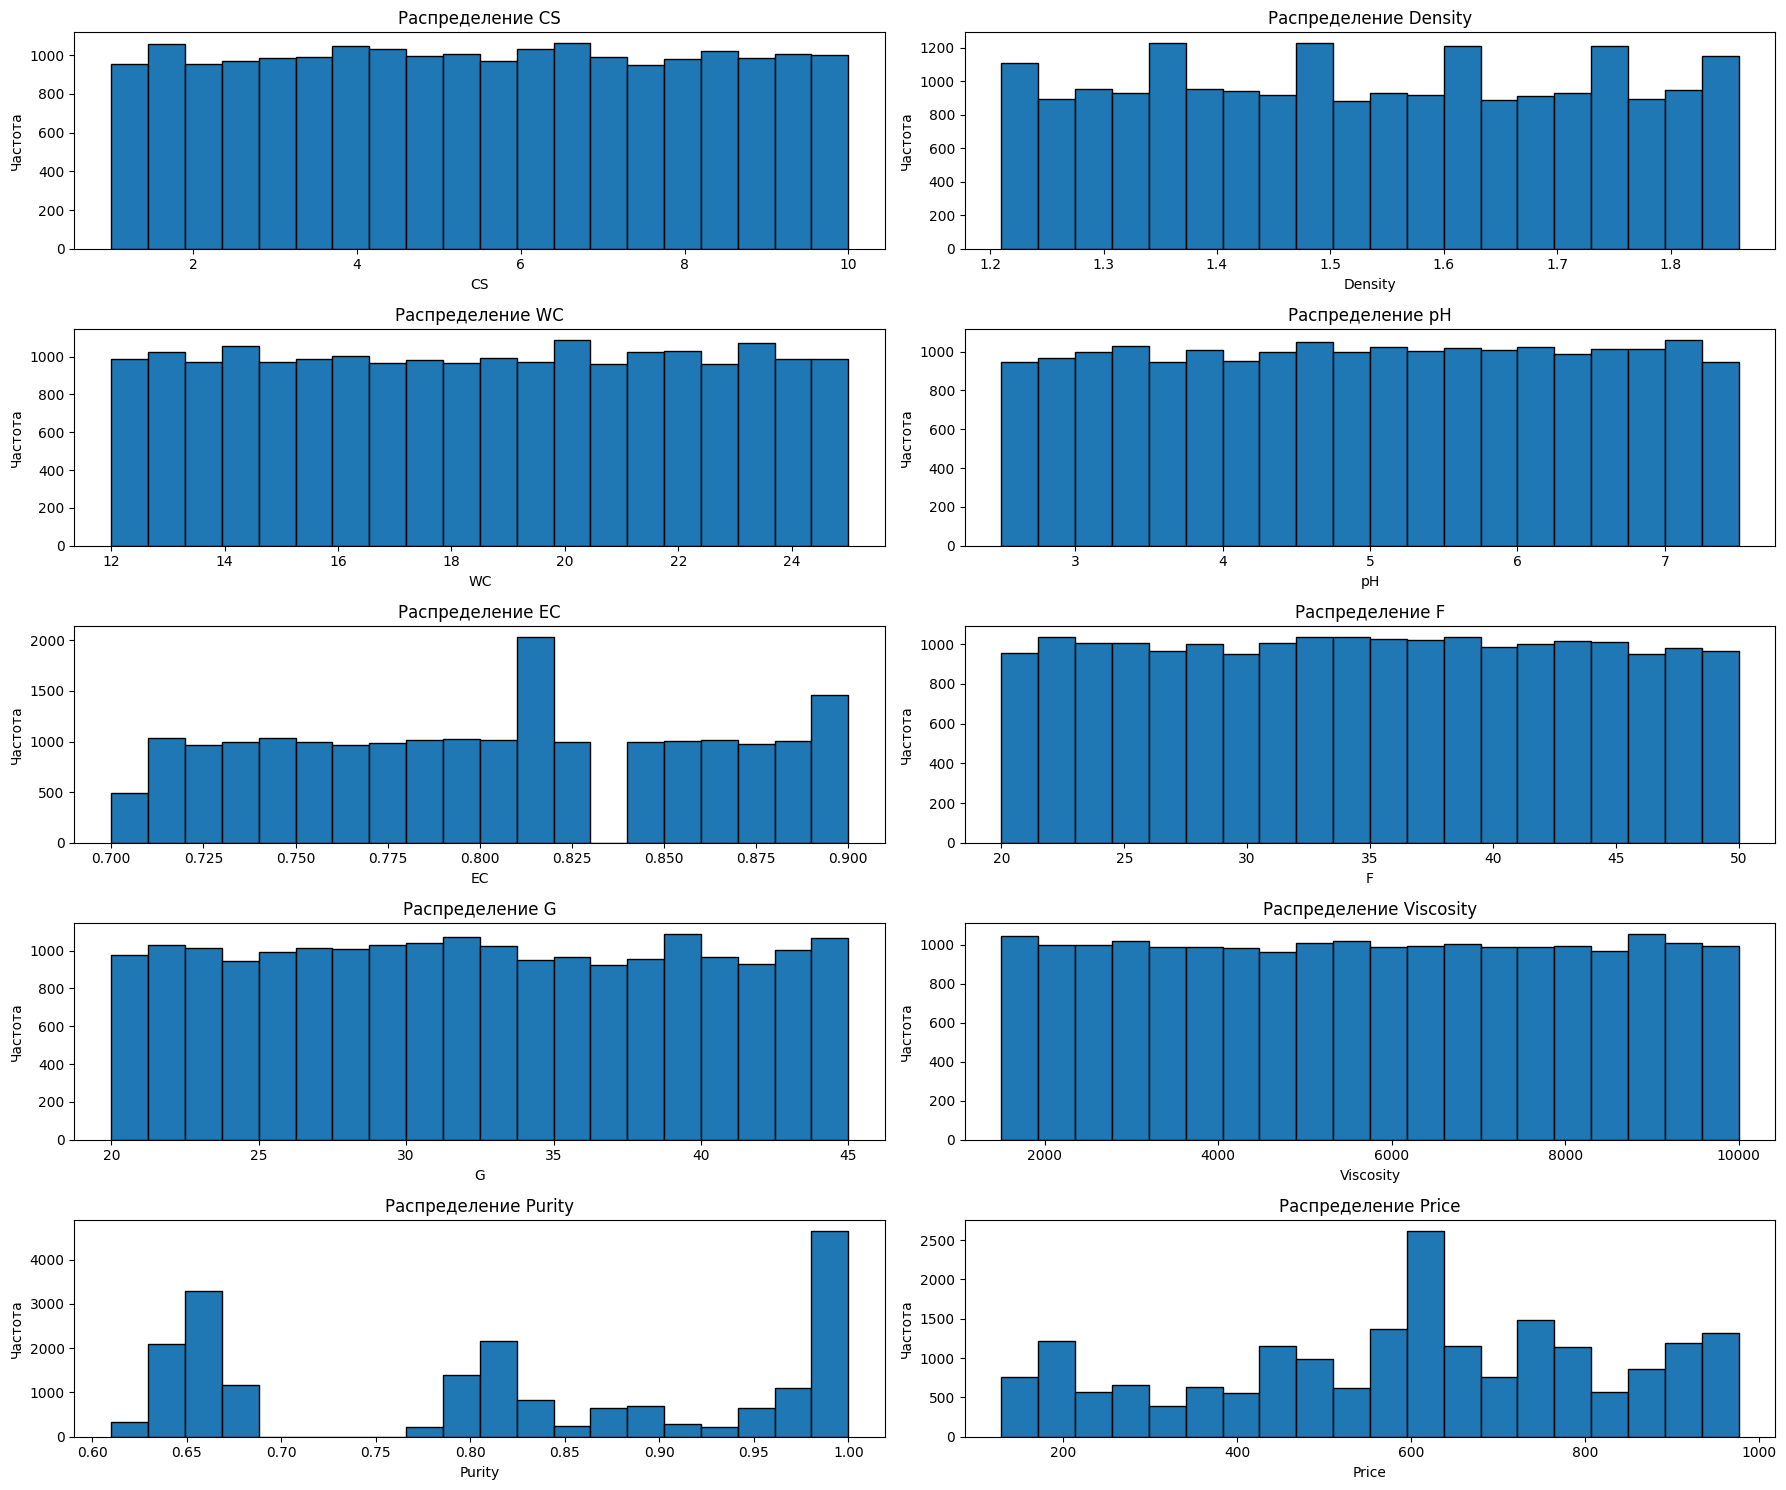

In [216]:
from matplotlib import pyplot as plt


num_cols = ['CS', 'Density', 'WC', 'pH', 'EC', 'F', 'G', 'Viscosity', 'Purity', 'Price']
cat_cols = ['Pollen_analysis']

fig, axes = plt.subplots(5, 2, figsize=(18, 15))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    axes[i].hist(honey_df[col], bins=20, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Посмотрим есть ли выбросы

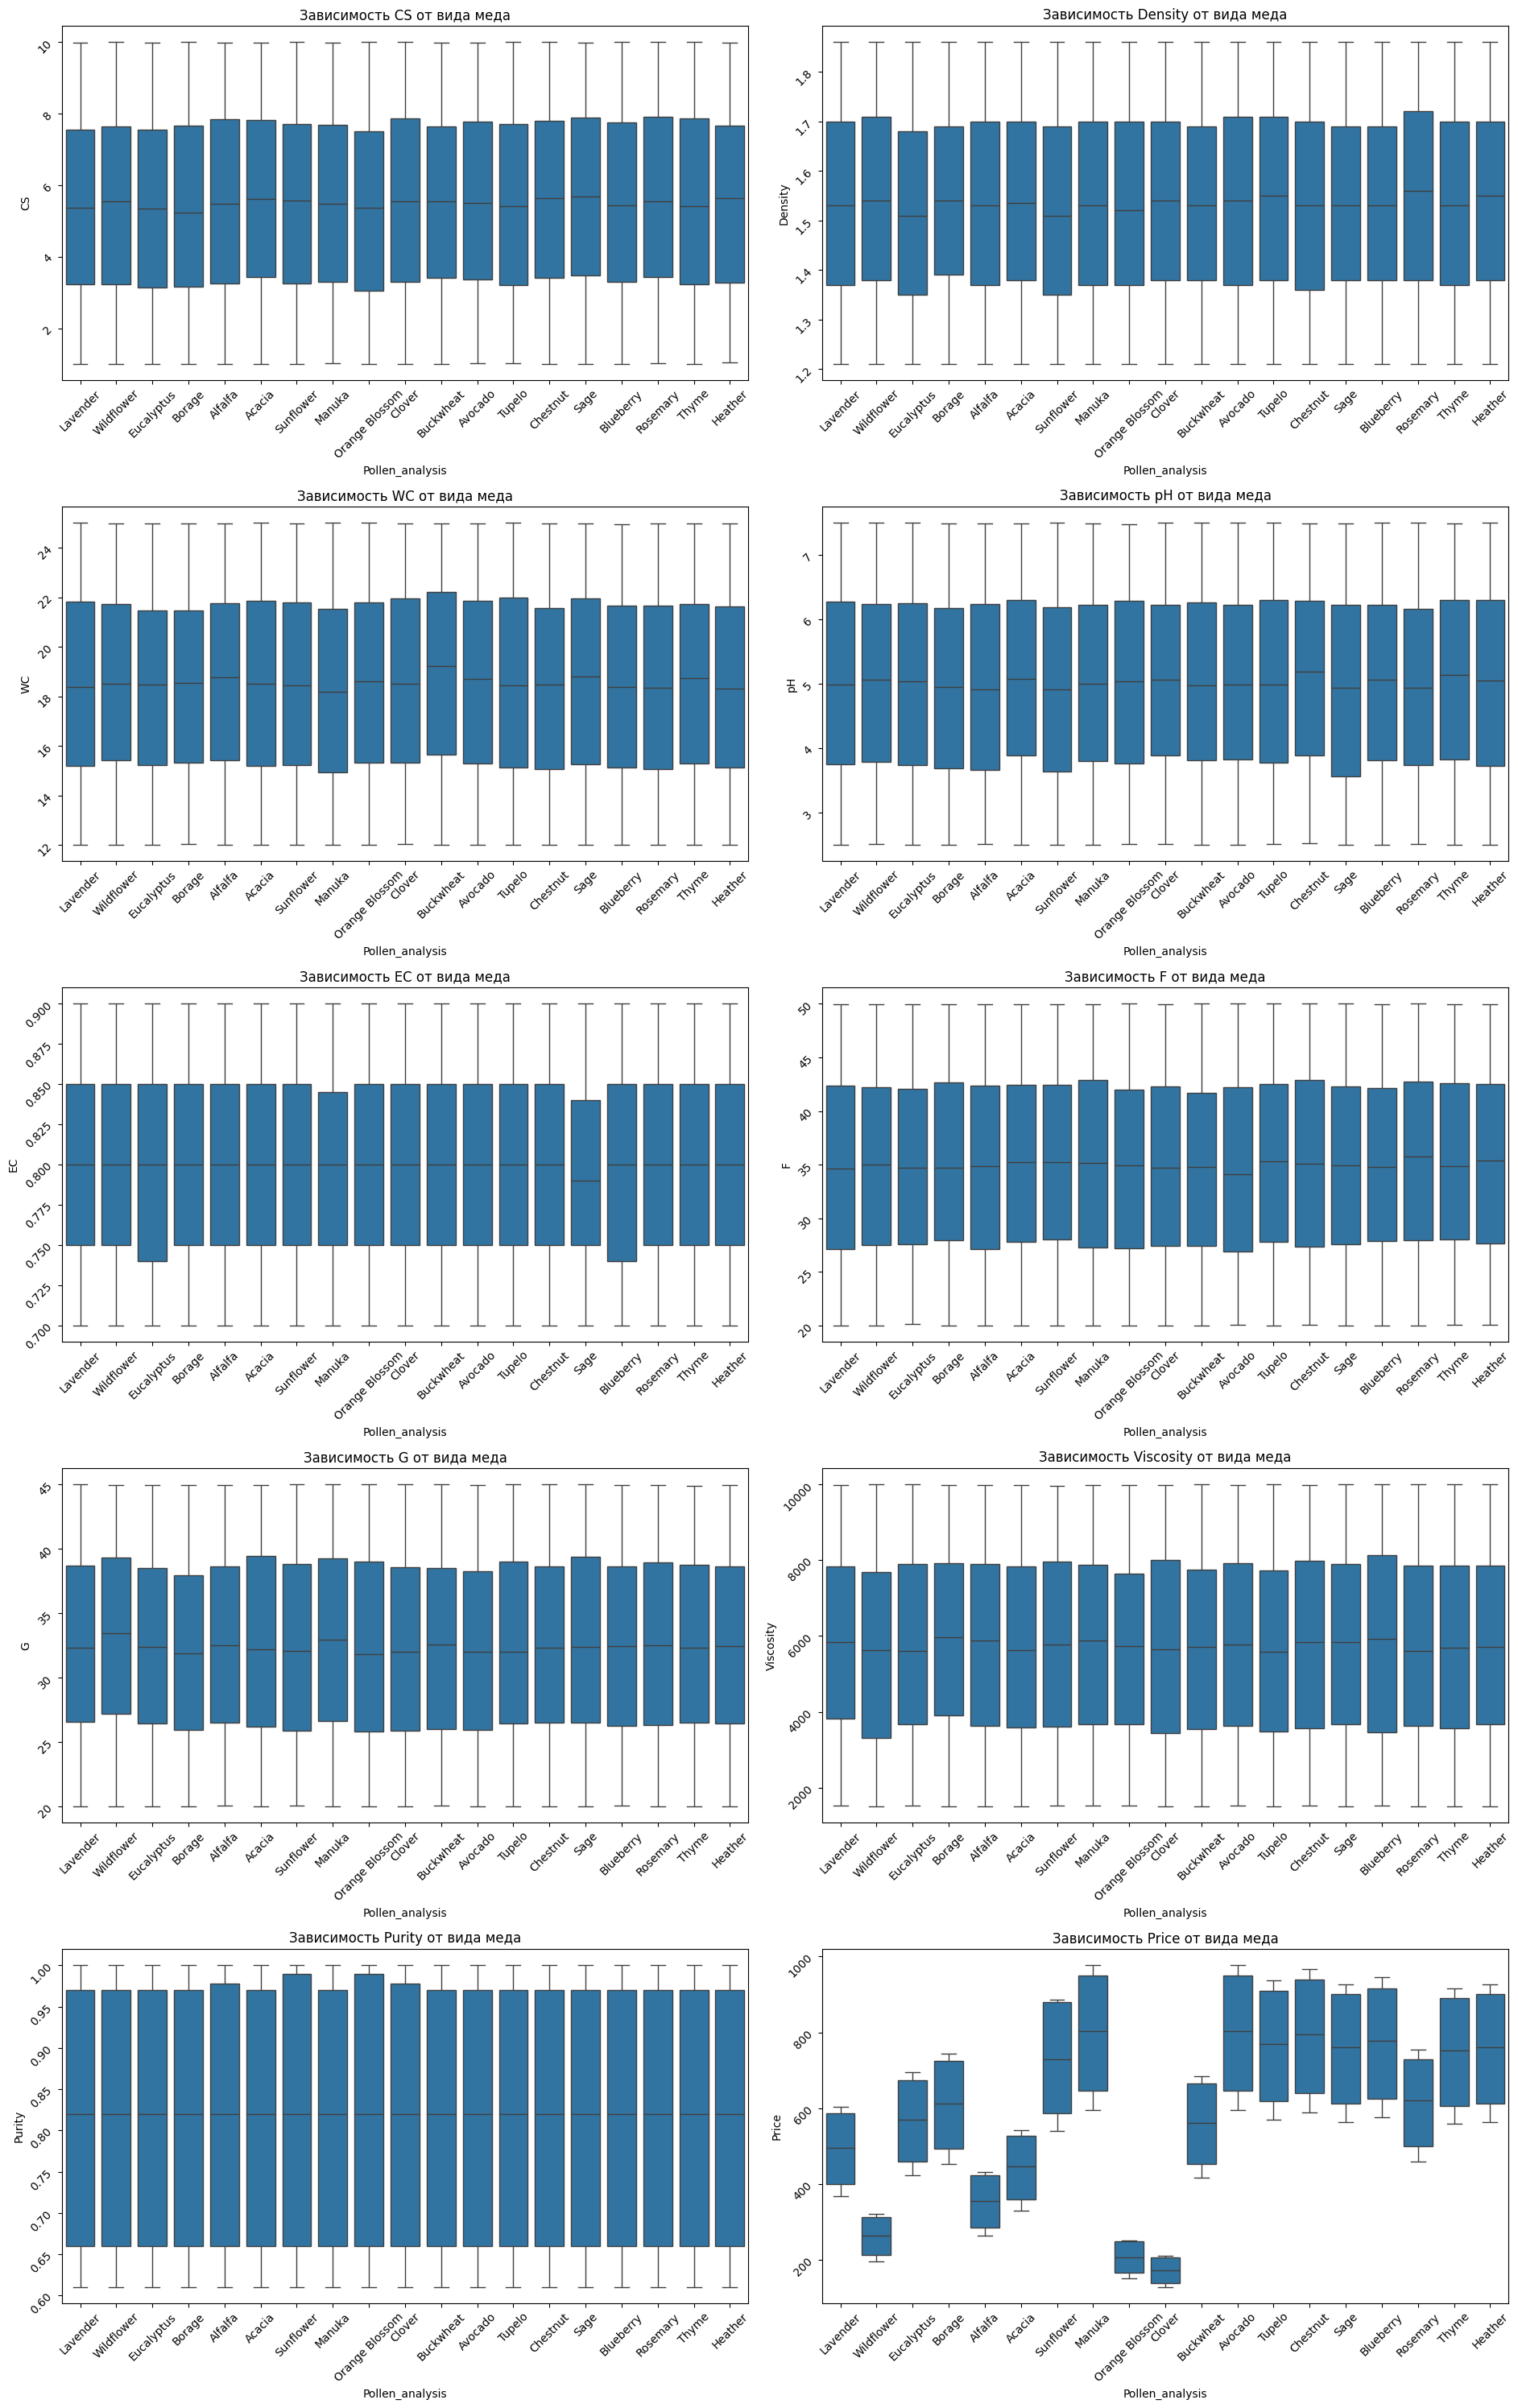

In [217]:
import seaborn as sns


fig, axes = plt.subplots(5, 2, figsize=(19, 30))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x='Pollen_analysis', y=col, data=honey_df, ax=axes[i])
    axes[i].set_title(f'Зависимость {col} от вида меда')
    axes[i].tick_params(rotation=45)

plt.tight_layout()
plt.show()

Выбросов нет

Посмотрим корреляцию

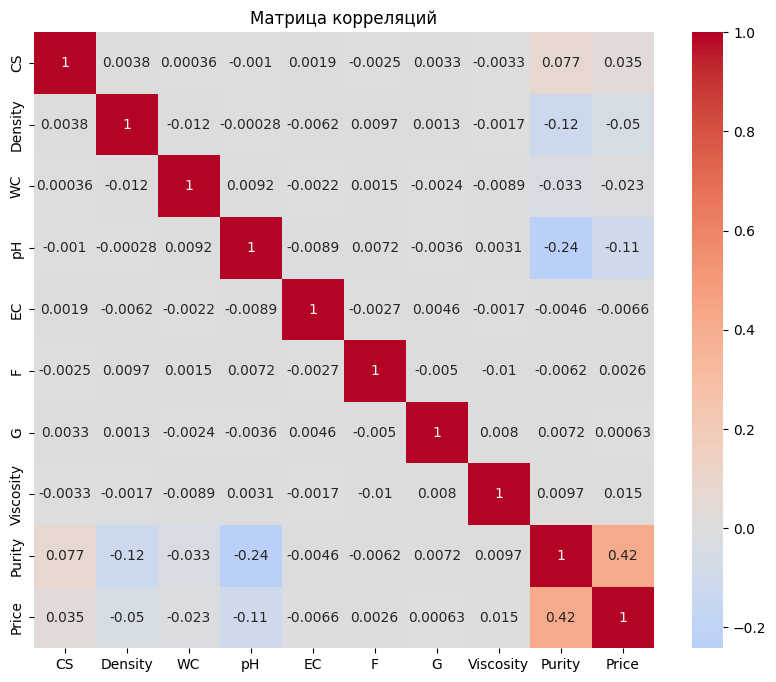

In [218]:
num_df = honey_df.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

Начнем создавать новые features

Числовые фичи

In [219]:
def create_num_features(df):
    new_df = df.copy()
    new_df['CS*Density'] = df['CS'] * df['Density']
    new_df['pH*EC'] = df['pH'] * df['EC']
    new_df['F/G'] = df['F'] / (df['G'] + 1e-9)
    new_df['WC*pH'] = df['WC'] * df['pH']
    new_df['Density*Viscosity/WC'] = df['Density'] * df['Viscosity'] / (df['WC'] + 1e-9)
    new_df['G/F'] = df['G'] / (df['F'] + 1e-9)
    new_df['EC/pH'] = df['EC'] / (df['pH'] + 1e-9)
    new_df['F+G'] = df['F'] + df['G']
    new_df['F/G'] = df['F'] / df['G']
    new_df['F*G/WC'] = df['F'] * df['G'] / (df['WC'] + 1e-9)
    new_df['log_Viscosity'] = np.log1p(df['Viscosity'])
    new_df['log_Total_Sugars'] = np.log1p(df['F'] + df['G'])
    new_df['pH_deviation_ideal'] = abs(df['pH'] - 4.0)
    new_df['WC_deviation_ideal'] = abs(df['WC'] - 18.6)
    new_df['Density_deviation'] = abs(df['Density'] - 1.42)
    new_df['log1p(CS*Density*WC*pH*EC*F*G*Viscosity)'] = np.log1p(df['CS'] * df['Density'] * df['WC'] * df['pH'] * df['EC'] * df['F'] * df['G'] * df['Viscosity'])
    for col in ['CS', 'Density', 'WC', 'pH', 'EC', 'F', 'G', 'Viscosity']:
        new_df[f'{col}_to_mean'] = df[col] / df[col].mean()
        
    return new_df

Создадим категориальные фичи

In [220]:
def create_cat_features(df):
    new_df = df.copy()
    new_df['WC_Category'] = pd.cut(df['WC'], 
                           bins=[12, 17, 19, 25],
                           labels=['low', 'medium', 'high'])
    new_df['Density_Category'] = pd.cut(df['Density'],
                                bins=[1.21, 1.45, 1.65, 1.86],
                                labels=['light', 'medium', 'dense'])
    new_df['pH_Category'] = pd.cut(df['pH'],
                           bins=[2.5, 3.9, 5.1, 7.5],
                           labels=['acidic', 'normal', 'alkaline'])
    
    cat_cols = ['Pollen_analysis', 'WC_Category', 'Density_Category', 'pH_Category']

    for col in cat_cols:
        dummies = pd.get_dummies(new_df[col], prefix=col, dtype=int, drop_first=True)
        new_df = pd.concat([new_df, dummies], axis=1)
    new_df = new_df.drop(columns=cat_cols)
    
    return new_df
    

Применим функции выше и построим матрицу корреляций

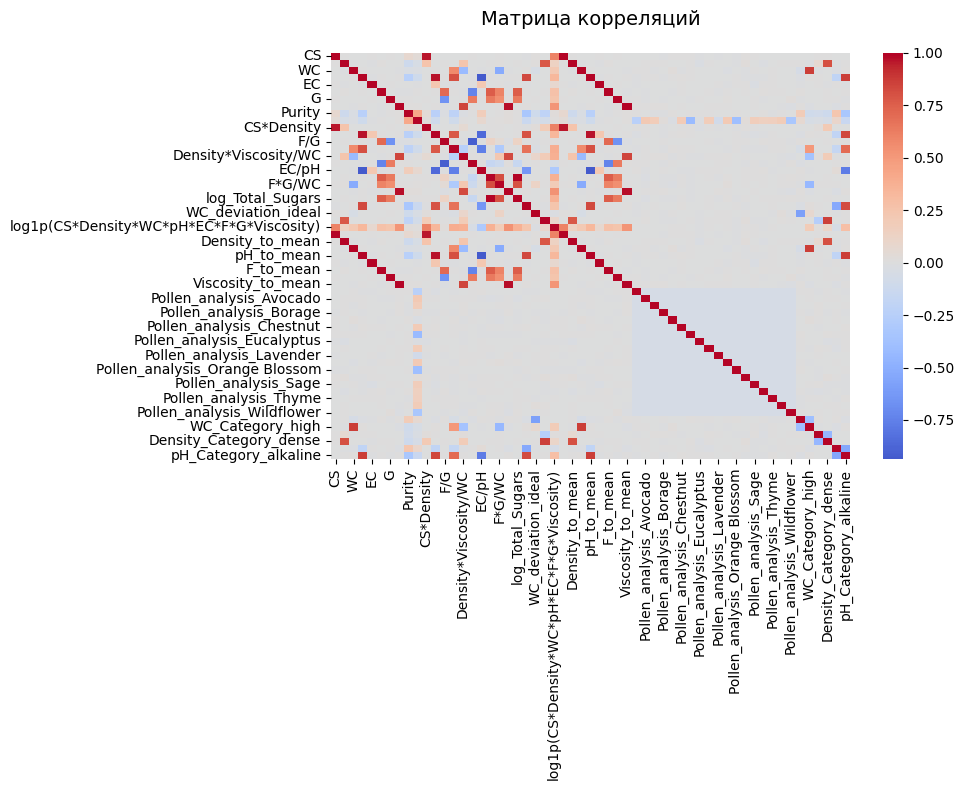

In [221]:
new_honey_df = create_num_features(honey_df)
new_honey_df = create_cat_features(new_honey_df)

corr_matrix = new_honey_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмотрим на результат после создания новых фич

In [222]:
from sklearn.discriminant_analysis import StandardScaler


honey_X = new_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = new_honey_df[['Purity', 'Price']]

scaler = StandardScaler()
honey_X = scaler.fit_transform(honey_X)

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [223]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = XGBRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                                          estimator  \
0  1.019237    0.007721  XGBRegressor(base_score=None, booster=None, ca...   
1  1.043104    0.007366  XGBRegressor(base_score=None, booster=None, ca...   
2  0.850617    0.008364  XGBRegressor(base_score=None, booster=None, ca...   
3  0.880972    0.007031  XGBRegressor(base_score=None, booster=None, ca...   
4  0.879681    0.009549  XGBRegressor(base_score=None, booster=None, ca...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.000554      -0.023527     -0.009388  0.971740  
1     -0.000505      -0.022472     -0.008141  0.974211  
2     -0.000489      -0.022119     -0.008756  0.974674  
3     -0.000478      -0.021858     -0.008719  0.974968  
4     -0.000509      -0.022553     -0.008565  0.973777  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                                          estimator  \
0  0.778239    0.0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Замерим результат на тестовой выборке

In [224]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9798959626335442
mse: 0.0003963175048436415
rmse: 0.019907724753061098
mae: 0.007168403974771493

Test_score Price:
r2: 0.9855684887150262
mse: 780.1399079575548
rmse: 27.930984729464065
mae: 16.32665474609375


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97990          | 0.98557          |
| mse              | 0.00040          | 780.13991        |
| rmse             | 0.01991          | 27.93098         |
| mae              | 0.00717          | 16.32665         |

Попробуем еще улучшить, подобрав гиперпараметры

In [225]:
import optuna
from sklearn.model_selection import cross_val_score

def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='r2', n_jobs=-1):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5),
            'random_state': 42,
            'n_jobs': n_jobs
        }
        
        model = XGBRegressor(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'Purity': {'n_estimators': 677, 'max_depth': 4, 'learning_rate': 0.10336760524492775, 'subsample': 0.834958120016406, 'colsample_bytree': 0.5050594261438264, 'min_child_weight': 3, 'gamma': 1.5224939650706326, 'reg_alpha': 0.5854607756419211, 'reg_lambda': 0.21980230812149745},
    'Price': {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.08830591222939779, 'subsample': 0.806091599585322, 'colsample_bytree': 0.8481995451557278, 'min_child_weight': 5, 'gamma': 0.4529151004137144, 'reg_alpha': 1.494715656992462, 'reg_lambda': 1.2296721793442582}
}

best_models = {}

for model_name in ['Purity', 'Price']:
    if not best_params.get(model_name):
        best_params[model_name] = find_best_hyperparameters_cv(
                honey_X_train,
                honey_y_train[model_name],
                n_trials=10,
                cv=5,
                scoring='neg_mean_absolute_error'
        )
    if not best_models.get(model_name):
        best_models[model_name] = XGBRegressor(**best_params[model_name])
        print(f"\n{model_name} model best params: {best_params[model_name]}\n")


Purity model best params: {'n_estimators': 677, 'max_depth': 4, 'learning_rate': 0.10336760524492775, 'subsample': 0.834958120016406, 'colsample_bytree': 0.5050594261438264, 'min_child_weight': 3, 'gamma': 1.5224939650706326, 'reg_alpha': 0.5854607756419211, 'reg_lambda': 0.21980230812149745}


Price model best params: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.08830591222939779, 'subsample': 0.806091599585322, 'colsample_bytree': 0.8481995451557278, 'min_child_weight': 5, 'gamma': 0.4529151004137144, 'reg_alpha': 1.494715656992462, 'reg_lambda': 1.2296721793442582}



Обучим модель с подобранными гиперпараметрами

In [226]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

results = {}


for model_name, model in best_models.items():
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                                          estimator  \
0  0.639328    0.009349  XGBRegressor(base_score=None, booster=None, ca...   
1  0.649930    0.010291  XGBRegressor(base_score=None, booster=None, ca...   
2  0.620290    0.010253  XGBRegressor(base_score=None, booster=None, ca...   
3  0.633587    0.012736  XGBRegressor(base_score=None, booster=None, ca...   
4  0.633987    0.010151  XGBRegressor(base_score=None, booster=None, ca...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.002740      -0.052343     -0.042740  0.860121  
1     -0.002615      -0.051134     -0.041293  0.866475  
2     -0.002765      -0.052580     -0.042724  0.856884  
3     -0.002729      -0.052239     -0.041949  0.857026  
4     -0.002723      -0.052178     -0.042881  0.859643  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                                          estimator  \
0  2.955715    0.0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Замерим на тестовой выборке

In [227]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))
    

Test_score Purity:
r2: 0.8588963947069007
mse: 0.0027816218083393674
rmse: 0.05274108273764739
mae: 0.043146779310703265

Test_score Price:
r2: 0.9906871270342393
mse: 503.4361069234455
rmse: 22.437381908846795
mae: 13.458343829574588


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.85890          | 0.99069          |
| mse              | 0.00278          | 503.43611        |
| rmse             | 0.05274          | 22.43738         |
| mae              | 0.04315          | 13.45834         |

#### Выводы:

Создание новых признаков и стандартизация дали минимальный прирост для Price (r2 с 0.98418 до 0.98557), но последующая оптимизация гиперпараметров дала неоднозначный результат: качество Purity значительно ухудшилось (r2=0.85890), в то время как Price улучшился до значения 0.99069. Это может объясняться:

1) Разной природой целевых переменных — Price имеет более сложные нелинейные зависимости.

2) Переобучением при оптимизации гиперпараметров для Purity.

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача регрессии

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import r2_score

class LabGradientBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0,
                 loss='ls', alpha=0.9, random_state=None, verbose=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.loss = loss
        self.alpha = alpha
        self.random_state = random_state
        self.verbose = verbose
        
        self.trees_ = []
        self.initial_prediction_ = None
        self.train_score_ = []
    
    def _compute_gradient(self, y, y_pred):
        if self.loss == 'ls':
            return y_pred - y
        elif self.loss == 'lad':
            return np.sign(y_pred - y)
        elif self.loss == 'huber':
            residual = y - y_pred
            abs_residual = np.abs(residual)
            gradient = np.where(
                abs_residual <= self.alpha,
                residual,
                self.alpha * np.sign(residual)
            )
            return gradient
        else:
            raise ValueError(f"Неподдерживаемая функция потерь: {self.loss}")
    
    def _initial_prediction(self, y):
        if self.loss == 'ls':
            return np.mean(y)
        elif self.loss == 'lad':
            return np.median(y)
        elif self.loss == 'huber':
            return np.mean(y)
    
    def fit(self, X, y, sample_weight=None):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X и y должны иметь одинаковое количество образцов")
        
        np.random.seed(self.random_state)
        self.trees_ = []
        n_samples = X.shape[0]
        
        self.initial_prediction_ = self._initial_prediction(y)
        y_pred = np.full(n_samples, self.initial_prediction_)
        
        for i in range(self.n_estimators):
            gradient = self._compute_gradient(y, y_pred)
            
            if self.subsample < 1.0:
                subsample_size = int(self.subsample * n_samples)
                indices = np.random.choice(n_samples, subsample_size, replace=False)
                X_subset = X[indices]
                gradient_subset = gradient[indices]
                sample_weight_subset = None
                if sample_weight is not None:
                    sample_weight_subset = sample_weight[indices]
            else:
                X_subset = X
                gradient_subset = gradient
                sample_weight_subset = sample_weight
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            
            tree.fit(X_subset, gradient_subset, sample_weight=sample_weight_subset)
            
            update = self.learning_rate * tree.predict(X)
            y_pred -= update
            
            self.trees_.append(tree)
            
            if self.verbose > 0 and (i + 1) % 10 == 0:
                if self.loss == 'ls':
                    mse = np.mean((y - y_pred) ** 2)
                    self.train_score_.append(mse)
                    if self.verbose > 1:
                        print(f"Iteration {i+1}/{self.n_estimators}, MSE: {mse:.4f}")
        
        return self
    
    def predict(self, X):
        if not hasattr(self, 'trees_') or len(self.trees_) == 0:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
        
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        y_pred = np.full(n_samples, self.initial_prediction_)
        
        for tree in self.trees_:
            y_pred -= self.learning_rate * tree.predict(X)
        
        return y_pred
    
    def staged_predict(self, X):
        if not hasattr(self, 'trees_') or len(self.trees_) == 0:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
        
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        y_pred = np.full(n_samples, self.initial_prediction_)
        
        yield y_pred.copy()
        
        for tree in self.trees_:
            y_pred -= self.learning_rate * tree.predict(X)
            yield y_pred.copy()
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'subsample': self.subsample,
            'loss': self.loss,
            'alpha': self.alpha,
            'random_state': self.random_state,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return r2_score(y, y_pred, sample_weight=sample_weight)

1. Простой бейзлайн

In [229]:
honey_X = onehot_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = onehot_honey_df[['Purity', 'Price']]
honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [230]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = LabGradientBoostRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                    estimator  test_neg_mse  \
0  4.023825    0.233176  LabGradientBoostRegressor()     -0.000837   
1  3.980297    0.211300  LabGradientBoostRegressor()     -0.000834   
2  3.947130    0.232436  LabGradientBoostRegressor()     -0.000934   
3  4.001118    0.217973  LabGradientBoostRegressor()     -0.000886   
4  3.975950    0.209373  LabGradientBoostRegressor()     -0.000851   

   test_neg_rmse  test_neg_mae   test_r2  
0      -0.028935     -0.019670  0.957255  
1      -0.028872     -0.019283  0.957430  
2      -0.030560     -0.020432  0.951653  
3      -0.029766     -0.019929  0.953579  
4      -0.029180     -0.019848  0.956102  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                    estimator  test_neg_mse  \
0  3.799765    0.210365  LabGradientBoostRegressor()  -4215.014638   
1  3.800180    0.210616  LabGradientBoostRegressor()  -4024.549143   
2  3.817104    0.2

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [231]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9575455086985281
mse: 0.0008369193587990041
rmse: 0.028929558565574484
mae: 0.019651800827379294

Test_score Price:
r2: 0.921109332287809
mse: 4264.678662710875
rmse: 65.30450721589494
mae: 50.58809334919506


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.95755          | 0.92111          |
| mse              | 0.00084          | 4264.67866       |
| rmse             | 0.02893          | 65.30451         |
| mae              | 0.01965          | 50.58809         |

#### Выводы:

LabGradientBoostRegressor показал хорошие, но не выдающиеся результаты на простом бейзлайне (Price: r2=0.92111 против 0.98418 у XGBoost).

Улучшим бейзлайн

In [232]:
new_honey_df = create_num_features(honey_df)
new_honey_df = create_cat_features(new_honey_df)

honey_X = new_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = new_honey_df[['Purity', 'Price']]

scaler = StandardScaler()
honey_X = scaler.fit_transform(honey_X)

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Посмотрим, что получилось после создания новых фич и применения StandardScaler

In [233]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = LabGradientBoostRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
    fit_time  score_time                    estimator  test_neg_mse  \
0  10.050487    0.018037  LabGradientBoostRegressor()     -0.000783   
1   9.979441    0.022267  LabGradientBoostRegressor()     -0.000816   
2  10.025684    0.023259  LabGradientBoostRegressor()     -0.000888   
3  10.044471    0.021919  LabGradientBoostRegressor()     -0.000857   
4  10.052790    0.018378  LabGradientBoostRegressor()     -0.000873   

   test_neg_rmse  test_neg_mae   test_r2  
0      -0.027983     -0.018207  0.960022  
1      -0.028569     -0.018409  0.958320  
2      -0.029794     -0.018923  0.954048  
3      -0.029277     -0.018691  0.955093  
4      -0.029548     -0.019365  0.954988  

Результаты кросс-валидации для Price модели:
    fit_time  score_time                    estimator  test_neg_mse  \
0  10.107582    0.018112  LabGradientBoostRegressor()  -3688.804965   
1  10.141812    0.022501  LabGradientBoostRegressor()  -3580.118631   
2  10.119

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [234]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9604979484227728
mse: 0.0007787169428670535
rmse: 0.027905500226067505
mae: 0.018155036503237576

Test_score Price:
r2: 0.9327800449803595
mse: 3633.7822481929147
rmse: 60.28086137567142
mae: 45.004960501197026


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.96050          | 0.93278          |
| mse              | 0.00078          | 3633.78225       |
| rmse             | 0.02791          | 60.28086         |
| mae              | 0.01816          | 45.00496         |

Попробуем еще улучшить, подобрав гиперпараметры

In [235]:
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='r2', n_jobs=-1):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'loss': trial.suggest_categorical('loss', ['ls', 'lad', 'huber'])
        }
        
        model = LabGradientBoostRegressor(**params, random_state=42)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'Purity': {'n_estimators': 379, 'learning_rate': 0.0909478696251934, 'max_depth': 3, 'min_samples_split': 20, 'subsample': 0.507167615250227, 'loss': 'ls'},
    'Price': {'n_estimators': 421, 'learning_rate': 0.03313580888029755, 'max_depth': 7, 'min_samples_split': 17, 'subsample': 0.9094465826972815, 'loss': 'ls'}
}

best_models = {}

for model_name in ['Purity', 'Price']:
    if not best_params.get(model_name):
        best_params[model_name] = find_best_hyperparameters_cv(
                honey_X_train,
                honey_y_train[model_name],
                n_trials=10,
                cv=5,
                scoring='neg_mean_absolute_error'
        )
    if not best_models.get(model_name):
        best_models[model_name] = LabGradientBoostRegressor(**best_params[model_name])

Обучим модель с подобранными гиперпараметрами

In [236]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

results = {}


for model_name, model in best_models.items():
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
    fit_time  score_time                                          estimator  \
0  19.660956    0.072890  LabGradientBoostRegressor(learning_rate=0.0909...   
1  19.853927    0.065315  LabGradientBoostRegressor(learning_rate=0.0909...   
2  19.664361    0.064782  LabGradientBoostRegressor(learning_rate=0.0909...   
3  19.707921    0.069398  LabGradientBoostRegressor(learning_rate=0.0909...   
4  19.737252    0.064714  LabGradientBoostRegressor(learning_rate=0.0909...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.000666      -0.025803     -0.015154  0.966007  
1     -0.000678      -0.026047     -0.014747  0.965355  
2     -0.000711      -0.026673     -0.014873  0.963171  
3     -0.000654      -0.025574     -0.014248  0.965733  
4     -0.000678      -0.026032     -0.015214  0.965064  

Результаты кросс-валидации для Price модели:
    fit_time  score_time                                          estimator  \
0  88.00372

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Замерим на тестовой выборке

In [237]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9690498116037755
mse: 0.0006101312495617761
rmse: 0.02470083499725821
mae: 0.013907396574064463

Test_score Price:
r2: 0.9764951506327725
mse: 1270.6272170536854
rmse: 35.64585834362367
mae: 19.423327422269946


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.96905          | 0.97650          |
| mse              | 0.00061          | 1270.62722       |
| rmse             | 0.02470          | 35.64586         |
| mae              | 0.01391          | 19.42333         |

#### Выводы:

После улучшений и оптимизации гиперпараметров качество значительно выросло (Price: r2=0.97650), приблизившись к библиотечной реализации. Это демонстрирует, что:

1) Базовая логика градиентного бустинга реализована корректно.

2) Качественная обработка данных и тонкая настройка гиперпараметров позволяют компенсировать упрощения в реализации.

3) Для регрессионных задач собственная реализация может быть достаточно эффективной.